In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2010250, 828)
(2010250, 8)
validation
(235568, 828)
(235568, 8)
test
(285739, 828)
(285739, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/202 [..............................] - ETA: 5:54 - loss: 2.4635 - STD: 0.0940 - MAE: 0.2213

  3/202 [..............................] - ETA: 5s - loss: 2.2609 - STD: 0.0517 - MAE: 0.2203  

  5/202 [..............................] - ETA: 5s - loss: 2.1797 - STD: 0.0477 - MAE: 0.2186

  7/202 [>.............................] - ETA: 5s - loss: 2.1563 - STD: 0.0568 - MAE: 0.2172

  9/202 [>.............................] - ETA: 5s - loss: 2.1407 - STD: 0.0595 - MAE: 0.2165

 11/202 [>.............................] - ETA: 4s - loss: 2.1297 - STD: 0.0574 - MAE: 0.2164

 13/202 [>.............................] - ETA: 4s - loss: 2.1224 - STD: 0.0541 - MAE: 0.2165

 15/202 [=>............................] - ETA: 4s - loss: 2.1150 - STD: 0.0508 - MAE: 0.2166

 17/202 [=>............................] - ETA: 4s - loss: 2.1077 - STD: 0.0481 - MAE: 0.2167

 19/202 [=>............................] - ETA: 4s - loss: 2.1017 - STD: 0.0464 - MAE: 0.2167

 21/202 [==>...........................] - ETA: 4s - loss: 2.0974 - STD: 0.0456 - MAE: 0.2166

 23/202 [==>...........................] - ETA: 4s - loss: 2.0940 - STD: 0.0450 - MAE: 0.2166

 25/202 [==>...........................] - ETA: 4s - loss: 2.0912 - STD: 0.0441 - MAE: 0.2166

 27/202 [===>..........................] - ETA: 4s - loss: 2.0882 - STD: 0.0428 - MAE: 0.2167

 29/202 [===>..........................] - ETA: 4s - loss: 2.0855 - STD: 0.0416 - MAE: 0.2167

 31/202 [===>..........................] - ETA: 4s - loss: 2.0831 - STD: 0.0406 - MAE: 0.2167

 33/202 [===>..........................] - ETA: 4s - loss: 2.0809 - STD: 0.0400 - MAE: 0.2167

 35/202 [====>.........................] - ETA: 4s - loss: 2.0786 - STD: 0.0396 - MAE: 0.2167

 37/202 [====>.........................] - ETA: 4s - loss: 2.0762 - STD: 0.0396 - MAE: 0.2166

 40/202 [====>.........................] - ETA: 4s - loss: 2.0727 - STD: 0.0396 - MAE: 0.2165

 42/202 [=====>........................] - ETA: 4s - loss: 2.0701 - STD: 0.0394 - MAE: 0.2165

 44/202 [=====>........................] - ETA: 4s - loss: 2.0672 - STD: 0.0392 - MAE: 0.2164

 46/202 [=====>........................] - ETA: 4s - loss: 2.0642 - STD: 0.0389 - MAE: 0.2163

 48/202 [======>.......................] - ETA: 3s - loss: 2.0608 - STD: 0.0388 - MAE: 0.2163

 50/202 [======>.......................] - ETA: 3s - loss: 2.0568 - STD: 0.0388 - MAE: 0.2161

 52/202 [======>.......................] - ETA: 3s - loss: 2.0525 - STD: 0.0390 - MAE: 0.2160

 55/202 [=======>......................] - ETA: 3s - loss: 2.0454 - STD: 0.0398 - MAE: 0.2157

 57/202 [=======>......................] - ETA: 3s - loss: 2.0407 - STD: 0.0406 - MAE: 0.2155

 59/202 [=======>......................] - ETA: 3s - loss: 2.0357 - STD: 0.0414 - MAE: 0.2153

 61/202 [========>.....................] - ETA: 3s - loss: 2.0306 - STD: 0.0423 - MAE: 0.2150

 63/202 [========>.....................] - ETA: 3s - loss: 2.0254 - STD: 0.0432 - MAE: 0.2148

 65/202 [========>.....................] - ETA: 3s - loss: 2.0204 - STD: 0.0441 - MAE: 0.2145

 67/202 [========>.....................] - ETA: 3s - loss: 2.0154 - STD: 0.0450 - MAE: 0.2143

 69/202 [=========>....................] - ETA: 3s - loss: 2.0102 - STD: 0.0459 - MAE: 0.2140

 72/202 [=========>....................] - ETA: 3s - loss: 2.0025 - STD: 0.0473 - MAE: 0.2137

 74/202 [=========>....................] - ETA: 3s - loss: 1.9974 - STD: 0.0482 - MAE: 0.2134

 76/202 [==========>...................] - ETA: 3s - loss: 1.9920 - STD: 0.0491 - MAE: 0.2131

 78/202 [==========>...................] - ETA: 3s - loss: 1.9865 - STD: 0.0499 - MAE: 0.2129

 80/202 [==========>...................] - ETA: 3s - loss: 1.9806 - STD: 0.0509 - MAE: 0.2126

 82/202 [===========>..................] - ETA: 3s - loss: 1.9742 - STD: 0.0518 - MAE: 0.2123

 84/202 [===========>..................] - ETA: 3s - loss: 1.9677 - STD: 0.0527 - MAE: 0.2119

 87/202 [===========>..................] - ETA: 2s - loss: 1.9582 - STD: 0.0541 - MAE: 0.2115

 89/202 [============>.................] - ETA: 2s - loss: 1.9517 - STD: 0.0551 - MAE: 0.2111

 91/202 [============>.................] - ETA: 2s - loss: 1.9452 - STD: 0.0560 - MAE: 0.2108

 93/202 [============>.................] - ETA: 2s - loss: 1.9386 - STD: 0.0569 - MAE: 0.2105

 95/202 [=============>................] - ETA: 2s - loss: 1.9320 - STD: 0.0579 - MAE: 0.2101

 97/202 [=============>................] - ETA: 2s - loss: 1.9254 - STD: 0.0589 - MAE: 0.2098

 99/202 [=============>................] - ETA: 2s - loss: 1.9188 - STD: 0.0598 - MAE: 0.2095

101/202 [==============>...............] - ETA: 2s - loss: 1.9120 - STD: 0.0607 - MAE: 0.2091

103/202 [==============>...............] - ETA: 2s - loss: 1.9052 - STD: 0.0616 - MAE: 0.2088

105/202 [==============>...............] - ETA: 2s - loss: 1.8983 - STD: 0.0626 - MAE: 0.2084

107/202 [==============>...............] - ETA: 2s - loss: 1.8912 - STD: 0.0635 - MAE: 0.2080

110/202 [===============>..............] - ETA: 2s - loss: 1.8806 - STD: 0.0650 - MAE: 0.2074

112/202 [===============>..............] - ETA: 2s - loss: 1.8734 - STD: 0.0660 - MAE: 0.2070

114/202 [===============>..............] - ETA: 2s - loss: 1.8661 - STD: 0.0670 - MAE: 0.2065

117/202 [================>.............] - ETA: 2s - loss: 1.8547 - STD: 0.0686 - MAE: 0.2059

119/202 [================>.............] - ETA: 2s - loss: 1.8472 - STD: 0.0696 - MAE: 0.2054

121/202 [================>.............] - ETA: 2s - loss: 1.8396 - STD: 0.0707 - MAE: 0.2049

123/202 [=================>............] - ETA: 2s - loss: 1.8319 - STD: 0.0718 - MAE: 0.2044

125/202 [=================>............] - ETA: 1s - loss: 1.8244 - STD: 0.0729 - MAE: 0.2039

128/202 [==================>...........] - ETA: 1s - loss: 1.8129 - STD: 0.0746 - MAE: 0.2032

130/202 [==================>...........] - ETA: 1s - loss: 1.8055 - STD: 0.0757 - MAE: 0.2027

132/202 [==================>...........] - ETA: 1s - loss: 1.7980 - STD: 0.0768 - MAE: 0.2022

134/202 [==================>...........] - ETA: 1s - loss: 1.7907 - STD: 0.0779 - MAE: 0.2017

136/202 [===================>..........] - ETA: 1s - loss: 1.7835 - STD: 0.0790 - MAE: 0.2012

138/202 [===================>..........] - ETA: 1s - loss: 1.7762 - STD: 0.0801 - MAE: 0.2006

141/202 [===================>..........] - ETA: 1s - loss: 1.7656 - STD: 0.0818 - MAE: 0.1999

143/202 [====================>.........] - ETA: 1s - loss: 1.7587 - STD: 0.0828 - MAE: 0.1994

145/202 [====================>.........] - ETA: 1s - loss: 1.7519 - STD: 0.0839 - MAE: 0.1989

147/202 [====================>.........] - ETA: 1s - loss: 1.7452 - STD: 0.0849 - MAE: 0.1984

149/202 [=====================>........] - ETA: 1s - loss: 1.7385 - STD: 0.0860 - MAE: 0.1979

151/202 [=====================>........] - ETA: 1s - loss: 1.7320 - STD: 0.0870 - MAE: 0.1974

153/202 [=====================>........] - ETA: 1s - loss: 1.7255 - STD: 0.0880 - MAE: 0.1969

156/202 [======================>.......] - ETA: 1s - loss: 1.7161 - STD: 0.0895 - MAE: 0.1962

159/202 [======================>.......] - ETA: 1s - loss: 1.7069 - STD: 0.0910 - MAE: 0.1955

161/202 [======================>.......] - ETA: 1s - loss: 1.7009 - STD: 0.0920 - MAE: 0.1950

163/202 [=======================>......] - ETA: 1s - loss: 1.6951 - STD: 0.0929 - MAE: 0.1946

165/202 [=======================>......] - ETA: 0s - loss: 1.6893 - STD: 0.0938 - MAE: 0.1941

167/202 [=======================>......] - ETA: 0s - loss: 1.6836 - STD: 0.0947 - MAE: 0.1937

169/202 [========================>.....] - ETA: 0s - loss: 1.6780 - STD: 0.0956 - MAE: 0.1932

171/202 [========================>.....] - ETA: 0s - loss: 1.6724 - STD: 0.0965 - MAE: 0.1928

173/202 [========================>.....] - ETA: 0s - loss: 1.6670 - STD: 0.0974 - MAE: 0.1924

175/202 [========================>.....] - ETA: 0s - loss: 1.6617 - STD: 0.0983 - MAE: 0.1919

177/202 [=========================>....] - ETA: 0s - loss: 1.6564 - STD: 0.0992 - MAE: 0.1915

179/202 [=========================>....] - ETA: 0s - loss: 1.6512 - STD: 0.1000 - MAE: 0.1911

181/202 [=========================>....] - ETA: 0s - loss: 1.6461 - STD: 0.1008 - MAE: 0.1907

183/202 [==========================>...] - ETA: 0s - loss: 1.6410 - STD: 0.1017 - MAE: 0.1903

185/202 [==========================>...] - ETA: 0s - loss: 1.6361 - STD: 0.1025 - MAE: 0.1899

187/202 [==========================>...] - ETA: 0s - loss: 1.6312 - STD: 0.1033 - MAE: 0.1895

189/202 [===========================>..] - ETA: 0s - loss: 1.6287 - STD: 0.1041 - MAE: 0.1891

191/202 [===========================>..] - ETA: 0s - loss: 1.6241 - STD: 0.1049 - MAE: 0.1887

193/202 [===========================>..] - ETA: 0s - loss: 1.6195 - STD: 0.1056 - MAE: 0.1883

194/202 [===========================>..] - ETA: 0s - loss: 1.6173 - STD: 0.1060 - MAE: 0.1881

196/202 [============================>.] - ETA: 0s - loss: 1.6127 - STD: 0.1067 - MAE: 0.1878

198/202 [============================>.] - ETA: 0s - loss: 1.6081 - STD: 0.1075 - MAE: 0.1874

200/202 [============================>.] - ETA: 0s - loss: 1.6038 - STD: 0.1082 - MAE: 0.1870

202/202 [==============================] - ETA: 0s - loss: 1.5995 - STD: 0.1089 - MAE: 0.1867

202/202 [==============================] - 9s 36ms/step - loss: 1.5995 - STD: 0.1089 - MAE: 0.1867 - val_loss: 1.1768 - val_STD: 0.1833 - val_MAE: 0.1518


Epoch 2/10000


  1/202 [..............................] - ETA: 12s - loss: 1.1648 - STD: 0.1792 - MAE: 0.1515

  3/202 [..............................] - ETA: 5s - loss: 1.1625 - STD: 0.1809 - MAE: 0.1507 

  5/202 [..............................] - ETA: 5s - loss: 1.1586 - STD: 0.1809 - MAE: 0.1505

  7/202 [>.............................] - ETA: 5s - loss: 1.1596 - STD: 0.1813 - MAE: 0.1504

  9/202 [>.............................] - ETA: 5s - loss: 1.1606 - STD: 0.1814 - MAE: 0.1504

 11/202 [>.............................] - ETA: 5s - loss: 1.1591 - STD: 0.1816 - MAE: 0.1503

 13/202 [>.............................] - ETA: 4s - loss: 1.1588 - STD: 0.1817 - MAE: 0.1502

 15/202 [=>............................] - ETA: 4s - loss: 1.1566 - STD: 0.1818 - MAE: 0.1500

 17/202 [=>............................] - ETA: 4s - loss: 1.1552 - STD: 0.1822 - MAE: 0.1498

 19/202 [=>............................] - ETA: 4s - loss: 1.1544 - STD: 0.1825 - MAE: 0.1497

 21/202 [==>...........................] - ETA: 4s - loss: 1.1532 - STD: 0.1827 - MAE: 0.1495

 23/202 [==>...........................] - ETA: 4s - loss: 1.1517 - STD: 0.1828 - MAE: 0.1494

 25/202 [==>...........................] - ETA: 4s - loss: 1.1504 - STD: 0.1829 - MAE: 0.1493

 27/202 [===>..........................] - ETA: 4s - loss: 1.1494 - STD: 0.1832 - MAE: 0.1491

 29/202 [===>..........................] - ETA: 4s - loss: 1.1486 - STD: 0.1835 - MAE: 0.1490

 31/202 [===>..........................] - ETA: 4s - loss: 1.1475 - STD: 0.1836 - MAE: 0.1489

 33/202 [===>..........................] - ETA: 4s - loss: 1.1464 - STD: 0.1837 - MAE: 0.1488

 35/202 [====>.........................] - ETA: 4s - loss: 1.1457 - STD: 0.1838 - MAE: 0.1487

 37/202 [====>.........................] - ETA: 4s - loss: 1.1449 - STD: 0.1840 - MAE: 0.1486

 39/202 [====>.........................] - ETA: 4s - loss: 1.1437 - STD: 0.1842 - MAE: 0.1485

 41/202 [=====>........................] - ETA: 4s - loss: 1.1428 - STD: 0.1844 - MAE: 0.1484

 43/202 [=====>........................] - ETA: 4s - loss: 1.1416 - STD: 0.1845 - MAE: 0.1483

 45/202 [=====>........................] - ETA: 4s - loss: 1.1408 - STD: 0.1846 - MAE: 0.1482

 47/202 [=====>........................] - ETA: 4s - loss: 1.1395 - STD: 0.1848 - MAE: 0.1480

 49/202 [======>.......................] - ETA: 4s - loss: 1.1387 - STD: 0.1850 - MAE: 0.1479

 51/202 [======>.......................] - ETA: 3s - loss: 1.1383 - STD: 0.1852 - MAE: 0.1479

 53/202 [======>.......................] - ETA: 3s - loss: 1.1380 - STD: 0.1853 - MAE: 0.1478

 55/202 [=======>......................] - ETA: 3s - loss: 1.1367 - STD: 0.1855 - MAE: 0.1476

 57/202 [=======>......................] - ETA: 3s - loss: 1.1367 - STD: 0.1857 - MAE: 0.1476

 59/202 [=======>......................] - ETA: 3s - loss: 1.1352 - STD: 0.1858 - MAE: 0.1475

 61/202 [========>.....................] - ETA: 3s - loss: 1.1341 - STD: 0.1860 - MAE: 0.1473

 63/202 [========>.....................] - ETA: 3s - loss: 1.1331 - STD: 0.1862 - MAE: 0.1472

 65/202 [========>.....................] - ETA: 3s - loss: 1.1319 - STD: 0.1863 - MAE: 0.1471

 67/202 [========>.....................] - ETA: 3s - loss: 1.1312 - STD: 0.1864 - MAE: 0.1470

 69/202 [=========>....................] - ETA: 3s - loss: 1.1303 - STD: 0.1866 - MAE: 0.1469

 71/202 [=========>....................] - ETA: 3s - loss: 1.1296 - STD: 0.1867 - MAE: 0.1468

 73/202 [=========>....................] - ETA: 3s - loss: 1.1288 - STD: 0.1868 - MAE: 0.1468

 75/202 [==========>...................] - ETA: 3s - loss: 1.1282 - STD: 0.1869 - MAE: 0.1467

 77/202 [==========>...................] - ETA: 3s - loss: 1.1274 - STD: 0.1871 - MAE: 0.1466

 79/202 [==========>...................] - ETA: 3s - loss: 1.1269 - STD: 0.1873 - MAE: 0.1465

 81/202 [===========>..................] - ETA: 3s - loss: 1.1258 - STD: 0.1874 - MAE: 0.1464

 83/202 [===========>..................] - ETA: 3s - loss: 1.1249 - STD: 0.1875 - MAE: 0.1463

 85/202 [===========>..................] - ETA: 3s - loss: 1.1243 - STD: 0.1877 - MAE: 0.1462

 87/202 [===========>..................] - ETA: 3s - loss: 1.1234 - STD: 0.1878 - MAE: 0.1461

 89/202 [============>.................] - ETA: 2s - loss: 1.1229 - STD: 0.1879 - MAE: 0.1460

 91/202 [============>.................] - ETA: 2s - loss: 1.1225 - STD: 0.1880 - MAE: 0.1460

 93/202 [============>.................] - ETA: 2s - loss: 1.1219 - STD: 0.1881 - MAE: 0.1459

 96/202 [=============>................] - ETA: 2s - loss: 1.1209 - STD: 0.1882 - MAE: 0.1458

 98/202 [=============>................] - ETA: 2s - loss: 1.1204 - STD: 0.1884 - MAE: 0.1457

100/202 [=============>................] - ETA: 2s - loss: 1.1198 - STD: 0.1885 - MAE: 0.1457

102/202 [==============>...............] - ETA: 2s - loss: 1.1192 - STD: 0.1886 - MAE: 0.1456

104/202 [==============>...............] - ETA: 2s - loss: 1.1184 - STD: 0.1888 - MAE: 0.1455

106/202 [==============>...............] - ETA: 2s - loss: 1.1178 - STD: 0.1889 - MAE: 0.1454

108/202 [===============>..............] - ETA: 2s - loss: 1.1169 - STD: 0.1890 - MAE: 0.1454

110/202 [===============>..............] - ETA: 2s - loss: 1.1161 - STD: 0.1891 - MAE: 0.1453

112/202 [===============>..............] - ETA: 2s - loss: 1.1154 - STD: 0.1892 - MAE: 0.1452

114/202 [===============>..............] - ETA: 2s - loss: 1.1146 - STD: 0.1893 - MAE: 0.1451

116/202 [================>.............] - ETA: 2s - loss: 1.1136 - STD: 0.1894 - MAE: 0.1450

118/202 [================>.............] - ETA: 2s - loss: 1.1130 - STD: 0.1895 - MAE: 0.1450

121/202 [================>.............] - ETA: 2s - loss: 1.1119 - STD: 0.1897 - MAE: 0.1448

123/202 [=================>............] - ETA: 2s - loss: 1.1109 - STD: 0.1898 - MAE: 0.1447

126/202 [=================>............] - ETA: 1s - loss: 1.1095 - STD: 0.1899 - MAE: 0.1446

129/202 [==================>...........] - ETA: 1s - loss: 1.1083 - STD: 0.1901 - MAE: 0.1445

131/202 [==================>...........] - ETA: 1s - loss: 1.1076 - STD: 0.1902 - MAE: 0.1444

133/202 [==================>...........] - ETA: 1s - loss: 1.1066 - STD: 0.1903 - MAE: 0.1443

135/202 [===================>..........] - ETA: 1s - loss: 1.1058 - STD: 0.1904 - MAE: 0.1442

138/202 [===================>..........] - ETA: 1s - loss: 1.1046 - STD: 0.1905 - MAE: 0.1441

141/202 [===================>..........] - ETA: 1s - loss: 1.1039 - STD: 0.1907 - MAE: 0.1440

143/202 [====================>.........] - ETA: 1s - loss: 1.1033 - STD: 0.1909 - MAE: 0.1439

145/202 [====================>.........] - ETA: 1s - loss: 1.1032 - STD: 0.1910 - MAE: 0.1438

147/202 [====================>.........] - ETA: 1s - loss: 1.1030 - STD: 0.1911 - MAE: 0.1438

149/202 [=====================>........] - ETA: 1s - loss: 1.1022 - STD: 0.1912 - MAE: 0.1437

151/202 [=====================>........] - ETA: 1s - loss: 1.1017 - STD: 0.1913 - MAE: 0.1437

153/202 [=====================>........] - ETA: 1s - loss: 1.1010 - STD: 0.1914 - MAE: 0.1436

155/202 [======================>.......] - ETA: 1s - loss: 1.1003 - STD: 0.1915 - MAE: 0.1435

157/202 [======================>.......] - ETA: 1s - loss: 1.0996 - STD: 0.1916 - MAE: 0.1434

159/202 [======================>.......] - ETA: 1s - loss: 1.0990 - STD: 0.1916 - MAE: 0.1434

161/202 [======================>.......] - ETA: 1s - loss: 1.0982 - STD: 0.1917 - MAE: 0.1433

163/202 [=======================>......] - ETA: 1s - loss: 1.0975 - STD: 0.1918 - MAE: 0.1432

166/202 [=======================>......] - ETA: 0s - loss: 1.0967 - STD: 0.1920 - MAE: 0.1431

168/202 [=======================>......] - ETA: 0s - loss: 1.0960 - STD: 0.1921 - MAE: 0.1431

170/202 [========================>.....] - ETA: 0s - loss: 1.0952 - STD: 0.1921 - MAE: 0.1430

172/202 [========================>.....] - ETA: 0s - loss: 1.0946 - STD: 0.1922 - MAE: 0.1429

174/202 [========================>.....] - ETA: 0s - loss: 1.0939 - STD: 0.1923 - MAE: 0.1429

176/202 [=========================>....] - ETA: 0s - loss: 1.0932 - STD: 0.1924 - MAE: 0.1428

178/202 [=========================>....] - ETA: 0s - loss: 1.0926 - STD: 0.1925 - MAE: 0.1427

180/202 [=========================>....] - ETA: 0s - loss: 1.0919 - STD: 0.1926 - MAE: 0.1426

182/202 [==========================>...] - ETA: 0s - loss: 1.0912 - STD: 0.1926 - MAE: 0.1426

184/202 [==========================>...] - ETA: 0s - loss: 1.0905 - STD: 0.1927 - MAE: 0.1425

186/202 [==========================>...] - ETA: 0s - loss: 1.0899 - STD: 0.1928 - MAE: 0.1424

188/202 [==========================>...] - ETA: 0s - loss: 1.0892 - STD: 0.1929 - MAE: 0.1424

190/202 [===========================>..] - ETA: 0s - loss: 1.0886 - STD: 0.1930 - MAE: 0.1423

192/202 [===========================>..] - ETA: 0s - loss: 1.0879 - STD: 0.1931 - MAE: 0.1422

194/202 [===========================>..] - ETA: 0s - loss: 1.0872 - STD: 0.1932 - MAE: 0.1422

196/202 [============================>.] - ETA: 0s - loss: 1.0866 - STD: 0.1932 - MAE: 0.1421

198/202 [============================>.] - ETA: 0s - loss: 1.0861 - STD: 0.1933 - MAE: 0.1420

200/202 [============================>.] - ETA: 0s - loss: 1.0853 - STD: 0.1934 - MAE: 0.1420

202/202 [==============================] - 6s 28ms/step - loss: 1.0846 - STD: 0.1935 - MAE: 0.1419 - val_loss: 1.0453 - val_STD: 0.2028 - val_MAE: 0.1364


Epoch 3/10000


  1/202 [..............................] - ETA: 12s - loss: 1.0177 - STD: 0.1988 - MAE: 0.1364

  3/202 [..............................] - ETA: 5s - loss: 1.0142 - STD: 0.2015 - MAE: 0.1349 

  5/202 [..............................] - ETA: 5s - loss: 1.0131 - STD: 0.2018 - MAE: 0.1347

  7/202 [>.............................] - ETA: 5s - loss: 1.0138 - STD: 0.2016 - MAE: 0.1347

  9/202 [>.............................] - ETA: 5s - loss: 1.0132 - STD: 0.2019 - MAE: 0.1346

 12/202 [>.............................] - ETA: 4s - loss: 1.0118 - STD: 0.2022 - MAE: 0.1344

 14/202 [=>............................] - ETA: 4s - loss: 1.0107 - STD: 0.2022 - MAE: 0.1343

 16/202 [=>............................] - ETA: 4s - loss: 1.0094 - STD: 0.2022 - MAE: 0.1343

 18/202 [=>............................] - ETA: 4s - loss: 1.0086 - STD: 0.2023 - MAE: 0.1342

 20/202 [=>............................] - ETA: 4s - loss: 1.0079 - STD: 0.2025 - MAE: 0.1341

 22/202 [==>...........................] - ETA: 4s - loss: 1.0095 - STD: 0.2026 - MAE: 0.1341

 24/202 [==>...........................] - ETA: 4s - loss: 1.0082 - STD: 0.2028 - MAE: 0.1340

 26/202 [==>...........................] - ETA: 4s - loss: 1.0074 - STD: 0.2028 - MAE: 0.1339

 28/202 [===>..........................] - ETA: 4s - loss: 1.0061 - STD: 0.2029 - MAE: 0.1338

 30/202 [===>..........................] - ETA: 4s - loss: 1.0048 - STD: 0.2029 - MAE: 0.1337

 32/202 [===>..........................] - ETA: 4s - loss: 1.0033 - STD: 0.2030 - MAE: 0.1336

 35/202 [====>.........................] - ETA: 4s - loss: 1.0039 - STD: 0.2033 - MAE: 0.1336

 38/202 [====>.........................] - ETA: 4s - loss: 1.0034 - STD: 0.2034 - MAE: 0.1335

 41/202 [=====>........................] - ETA: 4s - loss: 1.0029 - STD: 0.2036 - MAE: 0.1333

 44/202 [=====>........................] - ETA: 4s - loss: 1.0024 - STD: 0.2038 - MAE: 0.1332

 46/202 [=====>........................] - ETA: 3s - loss: 1.0021 - STD: 0.2039 - MAE: 0.1331

 48/202 [======>.......................] - ETA: 3s - loss: 1.0025 - STD: 0.2040 - MAE: 0.1331

 50/202 [======>.......................] - ETA: 3s - loss: 1.0024 - STD: 0.2040 - MAE: 0.1331

 52/202 [======>.......................] - ETA: 3s - loss: 1.0031 - STD: 0.2040 - MAE: 0.1332

 54/202 [=======>......................] - ETA: 3s - loss: 1.0032 - STD: 0.2041 - MAE: 0.1331

 56/202 [=======>......................] - ETA: 3s - loss: 1.0027 - STD: 0.2041 - MAE: 0.1331

 58/202 [=======>......................] - ETA: 3s - loss: 1.0017 - STD: 0.2042 - MAE: 0.1330

 60/202 [=======>......................] - ETA: 3s - loss: 1.0012 - STD: 0.2043 - MAE: 0.1329

 62/202 [========>.....................] - ETA: 3s - loss: 1.0004 - STD: 0.2043 - MAE: 0.1329

 64/202 [========>.....................] - ETA: 3s - loss: 0.9997 - STD: 0.2044 - MAE: 0.1328

 66/202 [========>.....................] - ETA: 3s - loss: 0.9993 - STD: 0.2044 - MAE: 0.1328

 68/202 [=========>....................] - ETA: 3s - loss: 0.9988 - STD: 0.2045 - MAE: 0.1327

 70/202 [=========>....................] - ETA: 3s - loss: 0.9982 - STD: 0.2046 - MAE: 0.1326

 72/202 [=========>....................] - ETA: 3s - loss: 0.9973 - STD: 0.2047 - MAE: 0.1325

 74/202 [=========>....................] - ETA: 3s - loss: 0.9966 - STD: 0.2048 - MAE: 0.1325

 76/202 [==========>...................] - ETA: 3s - loss: 0.9961 - STD: 0.2049 - MAE: 0.1324

 78/202 [==========>...................] - ETA: 3s - loss: 0.9957 - STD: 0.2050 - MAE: 0.1323

 80/202 [==========>...................] - ETA: 3s - loss: 0.9951 - STD: 0.2050 - MAE: 0.1323

 82/202 [===========>..................] - ETA: 3s - loss: 0.9952 - STD: 0.2051 - MAE: 0.1322

 84/202 [===========>..................] - ETA: 3s - loss: 0.9949 - STD: 0.2052 - MAE: 0.1322

 86/202 [===========>..................] - ETA: 2s - loss: 0.9943 - STD: 0.2053 - MAE: 0.1321

 88/202 [============>.................] - ETA: 2s - loss: 0.9937 - STD: 0.2053 - MAE: 0.1321

 90/202 [============>.................] - ETA: 2s - loss: 0.9933 - STD: 0.2054 - MAE: 0.1320

 92/202 [============>.................] - ETA: 2s - loss: 0.9929 - STD: 0.2054 - MAE: 0.1319

 94/202 [============>.................] - ETA: 2s - loss: 0.9922 - STD: 0.2055 - MAE: 0.1319

 96/202 [=============>................] - ETA: 2s - loss: 0.9916 - STD: 0.2056 - MAE: 0.1318

 98/202 [=============>................] - ETA: 2s - loss: 0.9911 - STD: 0.2056 - MAE: 0.1318

101/202 [==============>...............] - ETA: 2s - loss: 0.9905 - STD: 0.2057 - MAE: 0.1317

103/202 [==============>...............] - ETA: 2s - loss: 0.9900 - STD: 0.2058 - MAE: 0.1316

105/202 [==============>...............] - ETA: 2s - loss: 0.9893 - STD: 0.2058 - MAE: 0.1316

107/202 [==============>...............] - ETA: 2s - loss: 0.9887 - STD: 0.2059 - MAE: 0.1315

109/202 [===============>..............] - ETA: 2s - loss: 0.9881 - STD: 0.2060 - MAE: 0.1314

111/202 [===============>..............] - ETA: 2s - loss: 0.9875 - STD: 0.2061 - MAE: 0.1313

113/202 [===============>..............] - ETA: 2s - loss: 0.9870 - STD: 0.2061 - MAE: 0.1313

115/202 [================>.............] - ETA: 2s - loss: 0.9863 - STD: 0.2062 - MAE: 0.1312

117/202 [================>.............] - ETA: 2s - loss: 0.9860 - STD: 0.2063 - MAE: 0.1311

119/202 [================>.............] - ETA: 2s - loss: 0.9858 - STD: 0.2064 - MAE: 0.1311

121/202 [================>.............] - ETA: 2s - loss: 0.9857 - STD: 0.2065 - MAE: 0.1311

123/202 [=================>............] - ETA: 2s - loss: 0.9853 - STD: 0.2065 - MAE: 0.1310

125/202 [=================>............] - ETA: 1s - loss: 0.9850 - STD: 0.2066 - MAE: 0.1310

128/202 [==================>...........] - ETA: 1s - loss: 0.9841 - STD: 0.2067 - MAE: 0.1309

130/202 [==================>...........] - ETA: 1s - loss: 0.9836 - STD: 0.2067 - MAE: 0.1308

132/202 [==================>...........] - ETA: 1s - loss: 0.9829 - STD: 0.2068 - MAE: 0.1307

134/202 [==================>...........] - ETA: 1s - loss: 0.9823 - STD: 0.2069 - MAE: 0.1307

136/202 [===================>..........] - ETA: 1s - loss: 0.9819 - STD: 0.2070 - MAE: 0.1306

138/202 [===================>..........] - ETA: 1s - loss: 0.9815 - STD: 0.2070 - MAE: 0.1306

140/202 [===================>..........] - ETA: 1s - loss: 0.9809 - STD: 0.2071 - MAE: 0.1305

142/202 [====================>.........] - ETA: 1s - loss: 0.9806 - STD: 0.2072 - MAE: 0.1304

144/202 [====================>.........] - ETA: 1s - loss: 0.9800 - STD: 0.2073 - MAE: 0.1304

146/202 [====================>.........] - ETA: 1s - loss: 0.9796 - STD: 0.2074 - MAE: 0.1303

148/202 [====================>.........] - ETA: 1s - loss: 0.9790 - STD: 0.2074 - MAE: 0.1302

150/202 [=====================>........] - ETA: 1s - loss: 0.9786 - STD: 0.2075 - MAE: 0.1302

152/202 [=====================>........] - ETA: 1s - loss: 0.9780 - STD: 0.2075 - MAE: 0.1301

154/202 [=====================>........] - ETA: 1s - loss: 0.9777 - STD: 0.2076 - MAE: 0.1301

156/202 [======================>.......] - ETA: 1s - loss: 0.9771 - STD: 0.2077 - MAE: 0.1300

159/202 [======================>.......] - ETA: 1s - loss: 0.9763 - STD: 0.2078 - MAE: 0.1299

162/202 [=======================>......] - ETA: 1s - loss: 0.9758 - STD: 0.2079 - MAE: 0.1298

165/202 [=======================>......] - ETA: 0s - loss: 0.9753 - STD: 0.2080 - MAE: 0.1298

167/202 [=======================>......] - ETA: 0s - loss: 0.9748 - STD: 0.2081 - MAE: 0.1297

169/202 [========================>.....] - ETA: 0s - loss: 0.9743 - STD: 0.2081 - MAE: 0.1297

171/202 [========================>.....] - ETA: 0s - loss: 0.9738 - STD: 0.2082 - MAE: 0.1296

173/202 [========================>.....] - ETA: 0s - loss: 0.9733 - STD: 0.2082 - MAE: 0.1295

175/202 [========================>.....] - ETA: 0s - loss: 0.9729 - STD: 0.2083 - MAE: 0.1295

177/202 [=========================>....] - ETA: 0s - loss: 0.9725 - STD: 0.2084 - MAE: 0.1294

179/202 [=========================>....] - ETA: 0s - loss: 0.9721 - STD: 0.2084 - MAE: 0.1294

181/202 [=========================>....] - ETA: 0s - loss: 0.9718 - STD: 0.2085 - MAE: 0.1293

183/202 [==========================>...] - ETA: 0s - loss: 0.9713 - STD: 0.2086 - MAE: 0.1293

185/202 [==========================>...] - ETA: 0s - loss: 0.9708 - STD: 0.2086 - MAE: 0.1292

187/202 [==========================>...] - ETA: 0s - loss: 0.9703 - STD: 0.2087 - MAE: 0.1292

189/202 [===========================>..] - ETA: 0s - loss: 0.9700 - STD: 0.2088 - MAE: 0.1291

191/202 [===========================>..] - ETA: 0s - loss: 0.9694 - STD: 0.2089 - MAE: 0.1290

193/202 [===========================>..] - ETA: 0s - loss: 0.9691 - STD: 0.2089 - MAE: 0.1290

196/202 [============================>.] - ETA: 0s - loss: 0.9686 - STD: 0.2090 - MAE: 0.1289

198/202 [============================>.] - ETA: 0s - loss: 0.9682 - STD: 0.2091 - MAE: 0.1289

200/202 [============================>.] - ETA: 0s - loss: 0.9678 - STD: 0.2092 - MAE: 0.1288

202/202 [==============================] - 6s 28ms/step - loss: 0.9676 - STD: 0.2092 - MAE: 0.1288 - val_loss: 0.9944 - val_STD: 0.2161 - val_MAE: 0.1278


Epoch 4/10000


  1/202 [..............................] - ETA: 12s - loss: 0.9561 - STD: 0.2147 - MAE: 0.1260

  3/202 [..............................] - ETA: 5s - loss: 0.9468 - STD: 0.2145 - MAE: 0.1254 

  5/202 [..............................] - ETA: 5s - loss: 0.9396 - STD: 0.2156 - MAE: 0.1244

  7/202 [>.............................] - ETA: 5s - loss: 0.9321 - STD: 0.2156 - MAE: 0.1239

  9/202 [>.............................] - ETA: 5s - loss: 0.9291 - STD: 0.2157 - MAE: 0.1236

 11/202 [>.............................] - ETA: 5s - loss: 0.9270 - STD: 0.2157 - MAE: 0.1235

 13/202 [>.............................] - ETA: 5s - loss: 0.9253 - STD: 0.2155 - MAE: 0.1235

 15/202 [=>............................] - ETA: 4s - loss: 0.9239 - STD: 0.2158 - MAE: 0.1233

 17/202 [=>............................] - ETA: 4s - loss: 0.9252 - STD: 0.2158 - MAE: 0.1234

 19/202 [=>............................] - ETA: 4s - loss: 0.9260 - STD: 0.2157 - MAE: 0.1235

 21/202 [==>...........................] - ETA: 4s - loss: 0.9265 - STD: 0.2157 - MAE: 0.1235

 24/202 [==>...........................] - ETA: 4s - loss: 0.9244 - STD: 0.2160 - MAE: 0.1232

 26/202 [==>...........................] - ETA: 4s - loss: 0.9237 - STD: 0.2162 - MAE: 0.1231

 28/202 [===>..........................] - ETA: 4s - loss: 0.9220 - STD: 0.2164 - MAE: 0.1229

 30/202 [===>..........................] - ETA: 4s - loss: 0.9219 - STD: 0.2165 - MAE: 0.1229

 32/202 [===>..........................] - ETA: 4s - loss: 0.9218 - STD: 0.2165 - MAE: 0.1229

 34/202 [====>.........................] - ETA: 4s - loss: 0.9209 - STD: 0.2165 - MAE: 0.1228

 36/202 [====>.........................] - ETA: 4s - loss: 0.9205 - STD: 0.2166 - MAE: 0.1227

 38/202 [====>.........................] - ETA: 4s - loss: 0.9207 - STD: 0.2166 - MAE: 0.1227

 40/202 [====>.........................] - ETA: 4s - loss: 0.9203 - STD: 0.2167 - MAE: 0.1226

 42/202 [=====>........................] - ETA: 4s - loss: 0.9202 - STD: 0.2167 - MAE: 0.1226

 44/202 [=====>........................] - ETA: 4s - loss: 0.9193 - STD: 0.2168 - MAE: 0.1225

 46/202 [=====>........................] - ETA: 4s - loss: 0.9192 - STD: 0.2169 - MAE: 0.1225

 49/202 [======>.......................] - ETA: 4s - loss: 0.9197 - STD: 0.2169 - MAE: 0.1225

 51/202 [======>.......................] - ETA: 3s - loss: 0.9192 - STD: 0.2169 - MAE: 0.1225

 53/202 [======>.......................] - ETA: 3s - loss: 0.9186 - STD: 0.2169 - MAE: 0.1224

 55/202 [=======>......................] - ETA: 3s - loss: 0.9182 - STD: 0.2170 - MAE: 0.1224

 57/202 [=======>......................] - ETA: 3s - loss: 0.9179 - STD: 0.2171 - MAE: 0.1223

 59/202 [=======>......................] - ETA: 3s - loss: 0.9179 - STD: 0.2172 - MAE: 0.1223

 61/202 [========>.....................] - ETA: 3s - loss: 0.9177 - STD: 0.2172 - MAE: 0.1222

 63/202 [========>.....................] - ETA: 3s - loss: 0.9175 - STD: 0.2173 - MAE: 0.1222

 65/202 [========>.....................] - ETA: 3s - loss: 0.9169 - STD: 0.2173 - MAE: 0.1221

 67/202 [========>.....................] - ETA: 3s - loss: 0.9166 - STD: 0.2174 - MAE: 0.1221

 69/202 [=========>....................] - ETA: 3s - loss: 0.9161 - STD: 0.2174 - MAE: 0.1221

 71/202 [=========>....................] - ETA: 3s - loss: 0.9161 - STD: 0.2175 - MAE: 0.1220

 73/202 [=========>....................] - ETA: 3s - loss: 0.9158 - STD: 0.2175 - MAE: 0.1220

 75/202 [==========>...................] - ETA: 3s - loss: 0.9157 - STD: 0.2175 - MAE: 0.1220

 77/202 [==========>...................] - ETA: 3s - loss: 0.9154 - STD: 0.2176 - MAE: 0.1219

 79/202 [==========>...................] - ETA: 3s - loss: 0.9151 - STD: 0.2176 - MAE: 0.1219

 81/202 [===========>..................] - ETA: 3s - loss: 0.9147 - STD: 0.2176 - MAE: 0.1219

 83/202 [===========>..................] - ETA: 3s - loss: 0.9145 - STD: 0.2177 - MAE: 0.1218

 85/202 [===========>..................] - ETA: 3s - loss: 0.9140 - STD: 0.2177 - MAE: 0.1218

 87/202 [===========>..................] - ETA: 3s - loss: 0.9147 - STD: 0.2178 - MAE: 0.1218

 89/202 [============>.................] - ETA: 2s - loss: 0.9151 - STD: 0.2178 - MAE: 0.1218

 91/202 [============>.................] - ETA: 2s - loss: 0.9144 - STD: 0.2179 - MAE: 0.1217

 93/202 [============>.................] - ETA: 2s - loss: 0.9147 - STD: 0.2180 - MAE: 0.1217

 95/202 [=============>................] - ETA: 2s - loss: 0.9144 - STD: 0.2180 - MAE: 0.1217

 97/202 [=============>................] - ETA: 2s - loss: 0.9142 - STD: 0.2180 - MAE: 0.1217

100/202 [=============>................] - ETA: 2s - loss: 0.9137 - STD: 0.2181 - MAE: 0.1216

102/202 [==============>...............] - ETA: 2s - loss: 0.9133 - STD: 0.2181 - MAE: 0.1216

104/202 [==============>...............] - ETA: 2s - loss: 0.9128 - STD: 0.2182 - MAE: 0.1215

106/202 [==============>...............] - ETA: 2s - loss: 0.9123 - STD: 0.2182 - MAE: 0.1215

108/202 [===============>..............] - ETA: 2s - loss: 0.9119 - STD: 0.2182 - MAE: 0.1214

110/202 [===============>..............] - ETA: 2s - loss: 0.9113 - STD: 0.2183 - MAE: 0.1214

112/202 [===============>..............] - ETA: 2s - loss: 0.9111 - STD: 0.2184 - MAE: 0.1213

114/202 [===============>..............] - ETA: 2s - loss: 0.9106 - STD: 0.2184 - MAE: 0.1213

116/202 [================>.............] - ETA: 2s - loss: 0.9105 - STD: 0.2184 - MAE: 0.1213

118/202 [================>.............] - ETA: 2s - loss: 0.9104 - STD: 0.2185 - MAE: 0.1213

120/202 [================>.............] - ETA: 2s - loss: 0.9103 - STD: 0.2185 - MAE: 0.1212

123/202 [=================>............] - ETA: 2s - loss: 0.9100 - STD: 0.2185 - MAE: 0.1212

126/202 [=================>............] - ETA: 1s - loss: 0.9099 - STD: 0.2186 - MAE: 0.1212

128/202 [==================>...........] - ETA: 1s - loss: 0.9096 - STD: 0.2186 - MAE: 0.1212

130/202 [==================>...........] - ETA: 1s - loss: 0.9093 - STD: 0.2186 - MAE: 0.1211

132/202 [==================>...........] - ETA: 1s - loss: 0.9089 - STD: 0.2186 - MAE: 0.1211

134/202 [==================>...........] - ETA: 1s - loss: 0.9086 - STD: 0.2187 - MAE: 0.1210

136/202 [===================>..........] - ETA: 1s - loss: 0.9082 - STD: 0.2187 - MAE: 0.1210

138/202 [===================>..........] - ETA: 1s - loss: 0.9082 - STD: 0.2187 - MAE: 0.1210

140/202 [===================>..........] - ETA: 1s - loss: 0.9083 - STD: 0.2188 - MAE: 0.1210

142/202 [====================>.........] - ETA: 1s - loss: 0.9082 - STD: 0.2188 - MAE: 0.1209

144/202 [====================>.........] - ETA: 1s - loss: 0.9080 - STD: 0.2189 - MAE: 0.1209

147/202 [====================>.........] - ETA: 1s - loss: 0.9078 - STD: 0.2190 - MAE: 0.1209

150/202 [=====================>........] - ETA: 1s - loss: 0.9076 - STD: 0.2190 - MAE: 0.1208

152/202 [=====================>........] - ETA: 1s - loss: 0.9073 - STD: 0.2190 - MAE: 0.1208

155/202 [======================>.......] - ETA: 1s - loss: 0.9075 - STD: 0.2192 - MAE: 0.1207

157/202 [======================>.......] - ETA: 1s - loss: 0.9077 - STD: 0.2192 - MAE: 0.1207

159/202 [======================>.......] - ETA: 1s - loss: 0.9077 - STD: 0.2192 - MAE: 0.1207

161/202 [======================>.......] - ETA: 1s - loss: 0.9077 - STD: 0.2193 - MAE: 0.1207

164/202 [=======================>......] - ETA: 0s - loss: 0.9077 - STD: 0.2193 - MAE: 0.1207

166/202 [=======================>......] - ETA: 0s - loss: 0.9076 - STD: 0.2194 - MAE: 0.1206

168/202 [=======================>......] - ETA: 0s - loss: 0.9076 - STD: 0.2194 - MAE: 0.1206

170/202 [========================>.....] - ETA: 0s - loss: 0.9076 - STD: 0.2194 - MAE: 0.1206

172/202 [========================>.....] - ETA: 0s - loss: 0.9073 - STD: 0.2195 - MAE: 0.1206

174/202 [========================>.....] - ETA: 0s - loss: 0.9072 - STD: 0.2195 - MAE: 0.1206

176/202 [=========================>....] - ETA: 0s - loss: 0.9069 - STD: 0.2195 - MAE: 0.1205

178/202 [=========================>....] - ETA: 0s - loss: 0.9067 - STD: 0.2196 - MAE: 0.1205

180/202 [=========================>....] - ETA: 0s - loss: 0.9064 - STD: 0.2196 - MAE: 0.1205

182/202 [==========================>...] - ETA: 0s - loss: 0.9061 - STD: 0.2196 - MAE: 0.1204

184/202 [==========================>...] - ETA: 0s - loss: 0.9058 - STD: 0.2197 - MAE: 0.1204

186/202 [==========================>...] - ETA: 0s - loss: 0.9055 - STD: 0.2197 - MAE: 0.1204

188/202 [==========================>...] - ETA: 0s - loss: 0.9052 - STD: 0.2197 - MAE: 0.1204

191/202 [===========================>..] - ETA: 0s - loss: 0.9047 - STD: 0.2197 - MAE: 0.1203

193/202 [===========================>..] - ETA: 0s - loss: 0.9043 - STD: 0.2198 - MAE: 0.1203

195/202 [===========================>..] - ETA: 0s - loss: 0.9041 - STD: 0.2198 - MAE: 0.1202

197/202 [============================>.] - ETA: 0s - loss: 0.9038 - STD: 0.2198 - MAE: 0.1202

199/202 [============================>.] - ETA: 0s - loss: 0.9036 - STD: 0.2199 - MAE: 0.1202

201/202 [============================>.] - ETA: 0s - loss: 0.9033 - STD: 0.2199 - MAE: 0.1201

202/202 [==============================] - 6s 28ms/step - loss: 0.9032 - STD: 0.2199 - MAE: 0.1201 - val_loss: 0.9560 - val_STD: 0.2238 - val_MAE: 0.1218


Epoch 5/10000


  1/202 [..............................] - ETA: 12s - loss: 0.8769 - STD: 0.2219 - MAE: 0.1178

  3/202 [..............................] - ETA: 5s - loss: 0.8839 - STD: 0.2223 - MAE: 0.1178 

  5/202 [..............................] - ETA: 5s - loss: 0.8803 - STD: 0.2229 - MAE: 0.1174

  7/202 [>.............................] - ETA: 5s - loss: 0.8825 - STD: 0.2229 - MAE: 0.1176

  9/202 [>.............................] - ETA: 4s - loss: 0.8822 - STD: 0.2229 - MAE: 0.1175

 11/202 [>.............................] - ETA: 4s - loss: 0.8824 - STD: 0.2233 - MAE: 0.1173

 13/202 [>.............................] - ETA: 4s - loss: 0.8846 - STD: 0.2232 - MAE: 0.1176

 15/202 [=>............................] - ETA: 4s - loss: 0.8851 - STD: 0.2232 - MAE: 0.1176

 17/202 [=>............................] - ETA: 4s - loss: 0.8848 - STD: 0.2231 - MAE: 0.1177

 19/202 [=>............................] - ETA: 4s - loss: 0.8842 - STD: 0.2230 - MAE: 0.1177

 21/202 [==>...........................] - ETA: 4s - loss: 0.8826 - STD: 0.2231 - MAE: 0.1175

 23/202 [==>...........................] - ETA: 4s - loss: 0.8808 - STD: 0.2229 - MAE: 0.1175

 25/202 [==>...........................] - ETA: 4s - loss: 0.8801 - STD: 0.2230 - MAE: 0.1174

 27/202 [===>..........................] - ETA: 4s - loss: 0.8786 - STD: 0.2230 - MAE: 0.1173

 29/202 [===>..........................] - ETA: 4s - loss: 0.8775 - STD: 0.2230 - MAE: 0.1172

 31/202 [===>..........................] - ETA: 4s - loss: 0.8764 - STD: 0.2231 - MAE: 0.1171

 33/202 [===>..........................] - ETA: 4s - loss: 0.8758 - STD: 0.2231 - MAE: 0.1171

 35/202 [====>.........................] - ETA: 4s - loss: 0.8749 - STD: 0.2232 - MAE: 0.1170

 37/202 [====>.........................] - ETA: 4s - loss: 0.8742 - STD: 0.2232 - MAE: 0.1169

 39/202 [====>.........................] - ETA: 4s - loss: 0.8733 - STD: 0.2233 - MAE: 0.1168

 41/202 [=====>........................] - ETA: 4s - loss: 0.8728 - STD: 0.2234 - MAE: 0.1168

 43/202 [=====>........................] - ETA: 4s - loss: 0.8724 - STD: 0.2234 - MAE: 0.1167

 45/202 [=====>........................] - ETA: 4s - loss: 0.8720 - STD: 0.2235 - MAE: 0.1166

 47/202 [=====>........................] - ETA: 4s - loss: 0.8718 - STD: 0.2236 - MAE: 0.1166

 49/202 [======>.......................] - ETA: 3s - loss: 0.8714 - STD: 0.2236 - MAE: 0.1166

 51/202 [======>.......................] - ETA: 3s - loss: 0.8715 - STD: 0.2236 - MAE: 0.1165

 53/202 [======>.......................] - ETA: 3s - loss: 0.8715 - STD: 0.2237 - MAE: 0.1165

 55/202 [=======>......................] - ETA: 3s - loss: 0.8714 - STD: 0.2238 - MAE: 0.1165

 57/202 [=======>......................] - ETA: 3s - loss: 0.8713 - STD: 0.2239 - MAE: 0.1164

 59/202 [=======>......................] - ETA: 3s - loss: 0.8713 - STD: 0.2239 - MAE: 0.1164

 61/202 [========>.....................] - ETA: 3s - loss: 0.8712 - STD: 0.2240 - MAE: 0.1164

 63/202 [========>.....................] - ETA: 3s - loss: 0.8711 - STD: 0.2240 - MAE: 0.1163

 65/202 [========>.....................] - ETA: 3s - loss: 0.8711 - STD: 0.2241 - MAE: 0.1163

 67/202 [========>.....................] - ETA: 3s - loss: 0.8705 - STD: 0.2241 - MAE: 0.1163

 69/202 [=========>....................] - ETA: 3s - loss: 0.8701 - STD: 0.2241 - MAE: 0.1163

 71/202 [=========>....................] - ETA: 3s - loss: 0.8699 - STD: 0.2241 - MAE: 0.1163

 73/202 [=========>....................] - ETA: 3s - loss: 0.8692 - STD: 0.2241 - MAE: 0.1162

 75/202 [==========>...................] - ETA: 3s - loss: 0.8683 - STD: 0.2242 - MAE: 0.1161

 77/202 [==========>...................] - ETA: 3s - loss: 0.8681 - STD: 0.2242 - MAE: 0.1160

 79/202 [==========>...................] - ETA: 3s - loss: 0.8677 - STD: 0.2243 - MAE: 0.1160

 81/202 [===========>..................] - ETA: 3s - loss: 0.8678 - STD: 0.2243 - MAE: 0.1160

 83/202 [===========>..................] - ETA: 3s - loss: 0.8681 - STD: 0.2243 - MAE: 0.1160

 85/202 [===========>..................] - ETA: 3s - loss: 0.8676 - STD: 0.2243 - MAE: 0.1160

 87/202 [===========>..................] - ETA: 2s - loss: 0.8674 - STD: 0.2244 - MAE: 0.1159

 89/202 [============>.................] - ETA: 2s - loss: 0.8673 - STD: 0.2244 - MAE: 0.1159

 91/202 [============>.................] - ETA: 2s - loss: 0.8670 - STD: 0.2245 - MAE: 0.1158

 93/202 [============>.................] - ETA: 2s - loss: 0.8667 - STD: 0.2246 - MAE: 0.1158

 95/202 [=============>................] - ETA: 2s - loss: 0.8664 - STD: 0.2246 - MAE: 0.1158

 97/202 [=============>................] - ETA: 2s - loss: 0.8662 - STD: 0.2246 - MAE: 0.1158

 99/202 [=============>................] - ETA: 2s - loss: 0.8660 - STD: 0.2246 - MAE: 0.1157

101/202 [==============>...............] - ETA: 2s - loss: 0.8662 - STD: 0.2247 - MAE: 0.1157

104/202 [==============>...............] - ETA: 2s - loss: 0.8682 - STD: 0.2247 - MAE: 0.1158

106/202 [==============>...............] - ETA: 2s - loss: 0.8696 - STD: 0.2247 - MAE: 0.1159

108/202 [===============>..............] - ETA: 2s - loss: 0.8706 - STD: 0.2248 - MAE: 0.1159

110/202 [===============>..............] - ETA: 2s - loss: 0.8717 - STD: 0.2248 - MAE: 0.1160

113/202 [===============>..............] - ETA: 2s - loss: 0.8723 - STD: 0.2249 - MAE: 0.1160

115/202 [================>.............] - ETA: 2s - loss: 0.8725 - STD: 0.2249 - MAE: 0.1160

117/202 [================>.............] - ETA: 2s - loss: 0.8725 - STD: 0.2249 - MAE: 0.1160

120/202 [================>.............] - ETA: 2s - loss: 0.8721 - STD: 0.2249 - MAE: 0.1160

122/202 [=================>............] - ETA: 2s - loss: 0.8721 - STD: 0.2249 - MAE: 0.1160

124/202 [=================>............] - ETA: 2s - loss: 0.8722 - STD: 0.2249 - MAE: 0.1160

126/202 [=================>............] - ETA: 1s - loss: 0.8723 - STD: 0.2249 - MAE: 0.1160

128/202 [==================>...........] - ETA: 1s - loss: 0.8721 - STD: 0.2249 - MAE: 0.1160

130/202 [==================>...........] - ETA: 1s - loss: 0.8720 - STD: 0.2249 - MAE: 0.1160

132/202 [==================>...........] - ETA: 1s - loss: 0.8720 - STD: 0.2249 - MAE: 0.1160

134/202 [==================>...........] - ETA: 1s - loss: 0.8717 - STD: 0.2249 - MAE: 0.1160

136/202 [===================>..........] - ETA: 1s - loss: 0.8717 - STD: 0.2249 - MAE: 0.1159

139/202 [===================>..........] - ETA: 1s - loss: 0.8714 - STD: 0.2249 - MAE: 0.1159

141/202 [===================>..........] - ETA: 1s - loss: 0.8713 - STD: 0.2250 - MAE: 0.1159

143/202 [====================>.........] - ETA: 1s - loss: 0.8710 - STD: 0.2250 - MAE: 0.1159

145/202 [====================>.........] - ETA: 1s - loss: 0.8708 - STD: 0.2250 - MAE: 0.1159

148/202 [====================>.........] - ETA: 1s - loss: 0.8707 - STD: 0.2250 - MAE: 0.1158

151/202 [=====================>........] - ETA: 1s - loss: 0.8703 - STD: 0.2251 - MAE: 0.1158

154/202 [=====================>........] - ETA: 1s - loss: 0.8698 - STD: 0.2251 - MAE: 0.1158

156/202 [======================>.......] - ETA: 1s - loss: 0.8694 - STD: 0.2251 - MAE: 0.1157

158/202 [======================>.......] - ETA: 1s - loss: 0.8690 - STD: 0.2251 - MAE: 0.1157

160/202 [======================>.......] - ETA: 1s - loss: 0.8686 - STD: 0.2252 - MAE: 0.1156

162/202 [=======================>......] - ETA: 1s - loss: 0.8680 - STD: 0.2252 - MAE: 0.1156

164/202 [=======================>......] - ETA: 0s - loss: 0.8677 - STD: 0.2252 - MAE: 0.1156

166/202 [=======================>......] - ETA: 0s - loss: 0.8674 - STD: 0.2253 - MAE: 0.1155

168/202 [=======================>......] - ETA: 0s - loss: 0.8671 - STD: 0.2253 - MAE: 0.1155

170/202 [========================>.....] - ETA: 0s - loss: 0.8669 - STD: 0.2253 - MAE: 0.1155

172/202 [========================>.....] - ETA: 0s - loss: 0.8666 - STD: 0.2253 - MAE: 0.1154

174/202 [========================>.....] - ETA: 0s - loss: 0.8662 - STD: 0.2253 - MAE: 0.1154

176/202 [=========================>....] - ETA: 0s - loss: 0.8659 - STD: 0.2254 - MAE: 0.1154

178/202 [=========================>....] - ETA: 0s - loss: 0.8654 - STD: 0.2254 - MAE: 0.1153

180/202 [=========================>....] - ETA: 0s - loss: 0.8652 - STD: 0.2254 - MAE: 0.1153

183/202 [==========================>...] - ETA: 0s - loss: 0.8647 - STD: 0.2255 - MAE: 0.1153

185/202 [==========================>...] - ETA: 0s - loss: 0.8643 - STD: 0.2255 - MAE: 0.1152

187/202 [==========================>...] - ETA: 0s - loss: 0.8640 - STD: 0.2255 - MAE: 0.1152

189/202 [===========================>..] - ETA: 0s - loss: 0.8637 - STD: 0.2256 - MAE: 0.1152

191/202 [===========================>..] - ETA: 0s - loss: 0.8634 - STD: 0.2256 - MAE: 0.1151

193/202 [===========================>..] - ETA: 0s - loss: 0.8630 - STD: 0.2256 - MAE: 0.1151

196/202 [============================>.] - ETA: 0s - loss: 0.8627 - STD: 0.2257 - MAE: 0.1151

198/202 [============================>.] - ETA: 0s - loss: 0.8625 - STD: 0.2257 - MAE: 0.1150

201/202 [============================>.] - ETA: 0s - loss: 0.8621 - STD: 0.2257 - MAE: 0.1150

202/202 [==============================] - 6s 28ms/step - loss: 0.8620 - STD: 0.2257 - MAE: 0.1150 - val_loss: 0.9420 - val_STD: 0.2283 - val_MAE: 0.1187


Epoch 6/10000


  1/202 [..............................] - ETA: 10s - loss: 0.8516 - STD: 0.2298 - MAE: 0.1126

  4/202 [..............................] - ETA: 4s - loss: 0.8411 - STD: 0.2287 - MAE: 0.1124 

  7/202 [>.............................] - ETA: 4s - loss: 0.8411 - STD: 0.2288 - MAE: 0.1122

  9/202 [>.............................] - ETA: 4s - loss: 0.8380 - STD: 0.2289 - MAE: 0.1119

 11/202 [>.............................] - ETA: 4s - loss: 0.8395 - STD: 0.2290 - MAE: 0.1120

 13/202 [>.............................] - ETA: 4s - loss: 0.8399 - STD: 0.2287 - MAE: 0.1121

 15/202 [=>............................] - ETA: 4s - loss: 0.8402 - STD: 0.2287 - MAE: 0.1122

 17/202 [=>............................] - ETA: 4s - loss: 0.8413 - STD: 0.2288 - MAE: 0.1122

 19/202 [=>............................] - ETA: 4s - loss: 0.8396 - STD: 0.2288 - MAE: 0.1121

 21/202 [==>...........................] - ETA: 4s - loss: 0.8395 - STD: 0.2288 - MAE: 0.1121

 23/202 [==>...........................] - ETA: 4s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1121

 25/202 [==>...........................] - ETA: 4s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1122

 27/202 [===>..........................] - ETA: 4s - loss: 0.8389 - STD: 0.2289 - MAE: 0.1121

 29/202 [===>..........................] - ETA: 4s - loss: 0.8388 - STD: 0.2289 - MAE: 0.1121

 31/202 [===>..........................] - ETA: 4s - loss: 0.8379 - STD: 0.2289 - MAE: 0.1120

 33/202 [===>..........................] - ETA: 4s - loss: 0.8372 - STD: 0.2289 - MAE: 0.1120

 35/202 [====>.........................] - ETA: 4s - loss: 0.8378 - STD: 0.2289 - MAE: 0.1120

 37/202 [====>.........................] - ETA: 4s - loss: 0.8385 - STD: 0.2290 - MAE: 0.1120

 39/202 [====>.........................] - ETA: 4s - loss: 0.8375 - STD: 0.2289 - MAE: 0.1120

 41/202 [=====>........................] - ETA: 4s - loss: 0.8379 - STD: 0.2290 - MAE: 0.1120

 43/202 [=====>........................] - ETA: 4s - loss: 0.8369 - STD: 0.2291 - MAE: 0.1118

 45/202 [=====>........................] - ETA: 4s - loss: 0.8361 - STD: 0.2291 - MAE: 0.1118

 47/202 [=====>........................] - ETA: 3s - loss: 0.8350 - STD: 0.2292 - MAE: 0.1117

 49/202 [======>.......................] - ETA: 3s - loss: 0.8347 - STD: 0.2292 - MAE: 0.1117

 51/202 [======>.......................] - ETA: 3s - loss: 0.8346 - STD: 0.2293 - MAE: 0.1116

 54/202 [=======>......................] - ETA: 3s - loss: 0.8338 - STD: 0.2292 - MAE: 0.1116

 56/202 [=======>......................] - ETA: 3s - loss: 0.8334 - STD: 0.2293 - MAE: 0.1116

 58/202 [=======>......................] - ETA: 3s - loss: 0.8327 - STD: 0.2293 - MAE: 0.1115

 60/202 [=======>......................] - ETA: 3s - loss: 0.8323 - STD: 0.2293 - MAE: 0.1115

 63/202 [========>.....................] - ETA: 3s - loss: 0.8317 - STD: 0.2293 - MAE: 0.1114

 65/202 [========>.....................] - ETA: 3s - loss: 0.8313 - STD: 0.2294 - MAE: 0.1114

 67/202 [========>.....................] - ETA: 3s - loss: 0.8310 - STD: 0.2294 - MAE: 0.1114

 69/202 [=========>....................] - ETA: 3s - loss: 0.8305 - STD: 0.2294 - MAE: 0.1113

 71/202 [=========>....................] - ETA: 3s - loss: 0.8299 - STD: 0.2294 - MAE: 0.1113

 73/202 [=========>....................] - ETA: 3s - loss: 0.8300 - STD: 0.2295 - MAE: 0.1113

 76/202 [==========>...................] - ETA: 3s - loss: 0.8303 - STD: 0.2295 - MAE: 0.1112

 78/202 [==========>...................] - ETA: 3s - loss: 0.8303 - STD: 0.2296 - MAE: 0.1112

 80/202 [==========>...................] - ETA: 3s - loss: 0.8300 - STD: 0.2296 - MAE: 0.1112

 82/202 [===========>..................] - ETA: 3s - loss: 0.8296 - STD: 0.2296 - MAE: 0.1112

 84/202 [===========>..................] - ETA: 3s - loss: 0.8295 - STD: 0.2297 - MAE: 0.1111

 86/202 [===========>..................] - ETA: 2s - loss: 0.8293 - STD: 0.2297 - MAE: 0.1111

 88/202 [============>.................] - ETA: 2s - loss: 0.8287 - STD: 0.2297 - MAE: 0.1111

 90/202 [============>.................] - ETA: 2s - loss: 0.8282 - STD: 0.2297 - MAE: 0.1110

 92/202 [============>.................] - ETA: 2s - loss: 0.8279 - STD: 0.2298 - MAE: 0.1110

 94/202 [============>.................] - ETA: 2s - loss: 0.8274 - STD: 0.2298 - MAE: 0.1109

 96/202 [=============>................] - ETA: 2s - loss: 0.8271 - STD: 0.2298 - MAE: 0.1109

 99/202 [=============>................] - ETA: 2s - loss: 0.8268 - STD: 0.2299 - MAE: 0.1109

102/202 [==============>...............] - ETA: 2s - loss: 0.8270 - STD: 0.2299 - MAE: 0.1109

104/202 [==============>...............] - ETA: 2s - loss: 0.8287 - STD: 0.2299 - MAE: 0.1110

106/202 [==============>...............] - ETA: 2s - loss: 0.8289 - STD: 0.2300 - MAE: 0.1109

108/202 [===============>..............] - ETA: 2s - loss: 0.8292 - STD: 0.2300 - MAE: 0.1110

110/202 [===============>..............] - ETA: 2s - loss: 0.8290 - STD: 0.2300 - MAE: 0.1109

112/202 [===============>..............] - ETA: 2s - loss: 0.8290 - STD: 0.2301 - MAE: 0.1109

114/202 [===============>..............] - ETA: 2s - loss: 0.8287 - STD: 0.2301 - MAE: 0.1109

116/202 [================>.............] - ETA: 2s - loss: 0.8283 - STD: 0.2302 - MAE: 0.1109

118/202 [================>.............] - ETA: 2s - loss: 0.8283 - STD: 0.2302 - MAE: 0.1109

120/202 [================>.............] - ETA: 2s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1108

122/202 [=================>............] - ETA: 2s - loss: 0.8277 - STD: 0.2302 - MAE: 0.1108

125/202 [=================>............] - ETA: 1s - loss: 0.8272 - STD: 0.2303 - MAE: 0.1107

127/202 [=================>............] - ETA: 1s - loss: 0.8268 - STD: 0.2303 - MAE: 0.1107

129/202 [==================>...........] - ETA: 1s - loss: 0.8266 - STD: 0.2303 - MAE: 0.1107

131/202 [==================>...........] - ETA: 1s - loss: 0.8263 - STD: 0.2303 - MAE: 0.1106

133/202 [==================>...........] - ETA: 1s - loss: 0.8261 - STD: 0.2304 - MAE: 0.1106

135/202 [===================>..........] - ETA: 1s - loss: 0.8259 - STD: 0.2304 - MAE: 0.1106

137/202 [===================>..........] - ETA: 1s - loss: 0.8257 - STD: 0.2304 - MAE: 0.1106

139/202 [===================>..........] - ETA: 1s - loss: 0.8254 - STD: 0.2304 - MAE: 0.1106

141/202 [===================>..........] - ETA: 1s - loss: 0.8253 - STD: 0.2304 - MAE: 0.1106

144/202 [====================>.........] - ETA: 1s - loss: 0.8249 - STD: 0.2304 - MAE: 0.1105

147/202 [====================>.........] - ETA: 1s - loss: 0.8247 - STD: 0.2304 - MAE: 0.1105

149/202 [=====================>........] - ETA: 1s - loss: 0.8246 - STD: 0.2305 - MAE: 0.1105

152/202 [=====================>........] - ETA: 1s - loss: 0.8246 - STD: 0.2304 - MAE: 0.1105

154/202 [=====================>........] - ETA: 1s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1105

156/202 [======================>.......] - ETA: 1s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1105

158/202 [======================>.......] - ETA: 1s - loss: 0.8249 - STD: 0.2305 - MAE: 0.1105

160/202 [======================>.......] - ETA: 1s - loss: 0.8250 - STD: 0.2306 - MAE: 0.1105

162/202 [=======================>......] - ETA: 1s - loss: 0.8250 - STD: 0.2306 - MAE: 0.1105

164/202 [=======================>......] - ETA: 0s - loss: 0.8252 - STD: 0.2306 - MAE: 0.1105

166/202 [=======================>......] - ETA: 0s - loss: 0.8252 - STD: 0.2306 - MAE: 0.1105

168/202 [=======================>......] - ETA: 0s - loss: 0.8252 - STD: 0.2307 - MAE: 0.1104

170/202 [========================>.....] - ETA: 0s - loss: 0.8252 - STD: 0.2307 - MAE: 0.1104

172/202 [========================>.....] - ETA: 0s - loss: 0.8250 - STD: 0.2307 - MAE: 0.1104

174/202 [========================>.....] - ETA: 0s - loss: 0.8248 - STD: 0.2307 - MAE: 0.1104

177/202 [=========================>....] - ETA: 0s - loss: 0.8245 - STD: 0.2307 - MAE: 0.1104

179/202 [=========================>....] - ETA: 0s - loss: 0.8243 - STD: 0.2308 - MAE: 0.1103

181/202 [=========================>....] - ETA: 0s - loss: 0.8241 - STD: 0.2308 - MAE: 0.1103

183/202 [==========================>...] - ETA: 0s - loss: 0.8236 - STD: 0.2308 - MAE: 0.1103

185/202 [==========================>...] - ETA: 0s - loss: 0.8234 - STD: 0.2308 - MAE: 0.1103

187/202 [==========================>...] - ETA: 0s - loss: 0.8231 - STD: 0.2308 - MAE: 0.1102

189/202 [===========================>..] - ETA: 0s - loss: 0.8230 - STD: 0.2309 - MAE: 0.1102

191/202 [===========================>..] - ETA: 0s - loss: 0.8228 - STD: 0.2309 - MAE: 0.1102

193/202 [===========================>..] - ETA: 0s - loss: 0.8224 - STD: 0.2309 - MAE: 0.1102

195/202 [===========================>..] - ETA: 0s - loss: 0.8221 - STD: 0.2309 - MAE: 0.1101

197/202 [============================>.] - ETA: 0s - loss: 0.8217 - STD: 0.2309 - MAE: 0.1101

199/202 [============================>.] - ETA: 0s - loss: 0.8214 - STD: 0.2309 - MAE: 0.1101

202/202 [==============================] - ETA: 0s - loss: 0.8209 - STD: 0.2310 - MAE: 0.1100

202/202 [==============================] - 6s 28ms/step - loss: 0.8209 - STD: 0.2310 - MAE: 0.1100 - val_loss: 0.9666 - val_STD: 0.2318 - val_MAE: 0.1185


Epoch 7/10000


  1/202 [..............................] - ETA: 12s - loss: 0.8052 - STD: 0.2316 - MAE: 0.1086

  3/202 [..............................] - ETA: 4s - loss: 0.7935 - STD: 0.2323 - MAE: 0.1076 

  5/202 [..............................] - ETA: 4s - loss: 0.8013 - STD: 0.2328 - MAE: 0.1078

  8/202 [>.............................] - ETA: 4s - loss: 0.7982 - STD: 0.2328 - MAE: 0.1076

 10/202 [>.............................] - ETA: 4s - loss: 0.7967 - STD: 0.2331 - MAE: 0.1074

 12/202 [>.............................] - ETA: 4s - loss: 0.7976 - STD: 0.2331 - MAE: 0.1074

 14/202 [=>............................] - ETA: 4s - loss: 0.7981 - STD: 0.2329 - MAE: 0.1076

 16/202 [=>............................] - ETA: 4s - loss: 0.7983 - STD: 0.2331 - MAE: 0.1075

 18/202 [=>............................] - ETA: 4s - loss: 0.8009 - STD: 0.2331 - MAE: 0.1077

 20/202 [=>............................] - ETA: 4s - loss: 0.8018 - STD: 0.2331 - MAE: 0.1078

 22/202 [==>...........................] - ETA: 4s - loss: 0.8014 - STD: 0.2332 - MAE: 0.1077

 24/202 [==>...........................] - ETA: 4s - loss: 0.8008 - STD: 0.2332 - MAE: 0.1077

 26/202 [==>...........................] - ETA: 4s - loss: 0.8011 - STD: 0.2334 - MAE: 0.1076

 28/202 [===>..........................] - ETA: 4s - loss: 0.8018 - STD: 0.2334 - MAE: 0.1076

 30/202 [===>..........................] - ETA: 4s - loss: 0.8029 - STD: 0.2334 - MAE: 0.1077

 33/202 [===>..........................] - ETA: 4s - loss: 0.8024 - STD: 0.2335 - MAE: 0.1077

 35/202 [====>.........................] - ETA: 4s - loss: 0.8020 - STD: 0.2335 - MAE: 0.1077

 37/202 [====>.........................] - ETA: 4s - loss: 0.8016 - STD: 0.2334 - MAE: 0.1077

 39/202 [====>.........................] - ETA: 4s - loss: 0.8017 - STD: 0.2335 - MAE: 0.1076

 42/202 [=====>........................] - ETA: 4s - loss: 0.8018 - STD: 0.2334 - MAE: 0.1077

 45/202 [=====>........................] - ETA: 3s - loss: 0.8013 - STD: 0.2334 - MAE: 0.1076

 48/202 [======>.......................] - ETA: 3s - loss: 0.8024 - STD: 0.2335 - MAE: 0.1077

 50/202 [======>.......................] - ETA: 3s - loss: 0.8025 - STD: 0.2335 - MAE: 0.1077

 52/202 [======>.......................] - ETA: 3s - loss: 0.8028 - STD: 0.2336 - MAE: 0.1077

 54/202 [=======>......................] - ETA: 3s - loss: 0.8020 - STD: 0.2337 - MAE: 0.1076

 57/202 [=======>......................] - ETA: 3s - loss: 0.8051 - STD: 0.2338 - MAE: 0.1078

 59/202 [=======>......................] - ETA: 3s - loss: 0.8074 - STD: 0.2340 - MAE: 0.1079

 61/202 [========>.....................] - ETA: 3s - loss: 0.8099 - STD: 0.2339 - MAE: 0.1080

 63/202 [========>.....................] - ETA: 3s - loss: 0.8113 - STD: 0.2340 - MAE: 0.1081

 65/202 [========>.....................] - ETA: 3s - loss: 0.8130 - STD: 0.2340 - MAE: 0.1082

 67/202 [========>.....................] - ETA: 3s - loss: 0.8146 - STD: 0.2340 - MAE: 0.1083

 69/202 [=========>....................] - ETA: 3s - loss: 0.8147 - STD: 0.2340 - MAE: 0.1083

 71/202 [=========>....................] - ETA: 3s - loss: 0.8149 - STD: 0.2341 - MAE: 0.1083

 73/202 [=========>....................] - ETA: 3s - loss: 0.8155 - STD: 0.2341 - MAE: 0.1083

 75/202 [==========>...................] - ETA: 3s - loss: 0.8156 - STD: 0.2340 - MAE: 0.1084

 77/202 [==========>...................] - ETA: 3s - loss: 0.8156 - STD: 0.2340 - MAE: 0.1084

 79/202 [==========>...................] - ETA: 3s - loss: 0.8155 - STD: 0.2340 - MAE: 0.1084

 81/202 [===========>..................] - ETA: 3s - loss: 0.8152 - STD: 0.2339 - MAE: 0.1084

 83/202 [===========>..................] - ETA: 3s - loss: 0.8148 - STD: 0.2339 - MAE: 0.1084

 85/202 [===========>..................] - ETA: 2s - loss: 0.8147 - STD: 0.2338 - MAE: 0.1084

 87/202 [===========>..................] - ETA: 2s - loss: 0.8141 - STD: 0.2338 - MAE: 0.1084

 90/202 [============>.................] - ETA: 2s - loss: 0.8133 - STD: 0.2338 - MAE: 0.1083

 92/202 [============>.................] - ETA: 2s - loss: 0.8130 - STD: 0.2338 - MAE: 0.1083

 94/202 [============>.................] - ETA: 2s - loss: 0.8125 - STD: 0.2338 - MAE: 0.1083

 96/202 [=============>................] - ETA: 2s - loss: 0.8119 - STD: 0.2338 - MAE: 0.1082

 98/202 [=============>................] - ETA: 2s - loss: 0.8116 - STD: 0.2338 - MAE: 0.1082

100/202 [=============>................] - ETA: 2s - loss: 0.8108 - STD: 0.2338 - MAE: 0.1081

102/202 [==============>...............] - ETA: 2s - loss: 0.8102 - STD: 0.2338 - MAE: 0.1081

104/202 [==============>...............] - ETA: 2s - loss: 0.8098 - STD: 0.2338 - MAE: 0.1081

106/202 [==============>...............] - ETA: 2s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1080

108/202 [===============>..............] - ETA: 2s - loss: 0.8085 - STD: 0.2338 - MAE: 0.1080

110/202 [===============>..............] - ETA: 2s - loss: 0.8081 - STD: 0.2338 - MAE: 0.1080

112/202 [===============>..............] - ETA: 2s - loss: 0.8076 - STD: 0.2338 - MAE: 0.1079

114/202 [===============>..............] - ETA: 2s - loss: 0.8072 - STD: 0.2338 - MAE: 0.1079

116/202 [================>.............] - ETA: 2s - loss: 0.8066 - STD: 0.2338 - MAE: 0.1078

118/202 [================>.............] - ETA: 2s - loss: 0.8061 - STD: 0.2339 - MAE: 0.1078

120/202 [================>.............] - ETA: 2s - loss: 0.8057 - STD: 0.2339 - MAE: 0.1077

122/202 [=================>............] - ETA: 2s - loss: 0.8053 - STD: 0.2339 - MAE: 0.1077

124/202 [=================>............] - ETA: 1s - loss: 0.8048 - STD: 0.2340 - MAE: 0.1077

126/202 [=================>............] - ETA: 1s - loss: 0.8043 - STD: 0.2340 - MAE: 0.1076

128/202 [==================>...........] - ETA: 1s - loss: 0.8037 - STD: 0.2340 - MAE: 0.1076

130/202 [==================>...........] - ETA: 1s - loss: 0.8033 - STD: 0.2340 - MAE: 0.1075

132/202 [==================>...........] - ETA: 1s - loss: 0.8029 - STD: 0.2341 - MAE: 0.1075

134/202 [==================>...........] - ETA: 1s - loss: 0.8025 - STD: 0.2341 - MAE: 0.1074

136/202 [===================>..........] - ETA: 1s - loss: 0.8022 - STD: 0.2341 - MAE: 0.1074

138/202 [===================>..........] - ETA: 1s - loss: 0.8018 - STD: 0.2341 - MAE: 0.1074

140/202 [===================>..........] - ETA: 1s - loss: 0.8014 - STD: 0.2342 - MAE: 0.1073

142/202 [====================>.........] - ETA: 1s - loss: 0.8009 - STD: 0.2342 - MAE: 0.1073

144/202 [====================>.........] - ETA: 1s - loss: 0.8004 - STD: 0.2342 - MAE: 0.1073

146/202 [====================>.........] - ETA: 1s - loss: 0.8002 - STD: 0.2342 - MAE: 0.1072

148/202 [====================>.........] - ETA: 1s - loss: 0.8001 - STD: 0.2343 - MAE: 0.1072

150/202 [=====================>........] - ETA: 1s - loss: 0.7999 - STD: 0.2343 - MAE: 0.1072

152/202 [=====================>........] - ETA: 1s - loss: 0.7997 - STD: 0.2343 - MAE: 0.1072

154/202 [=====================>........] - ETA: 1s - loss: 0.7992 - STD: 0.2343 - MAE: 0.1071

156/202 [======================>.......] - ETA: 1s - loss: 0.7988 - STD: 0.2344 - MAE: 0.1071

158/202 [======================>.......] - ETA: 1s - loss: 0.7988 - STD: 0.2344 - MAE: 0.1071

160/202 [======================>.......] - ETA: 1s - loss: 0.7985 - STD: 0.2344 - MAE: 0.1070

162/202 [=======================>......] - ETA: 1s - loss: 0.7982 - STD: 0.2345 - MAE: 0.1070

164/202 [=======================>......] - ETA: 0s - loss: 0.7978 - STD: 0.2345 - MAE: 0.1070

166/202 [=======================>......] - ETA: 0s - loss: 0.7981 - STD: 0.2345 - MAE: 0.1070

168/202 [=======================>......] - ETA: 0s - loss: 0.7977 - STD: 0.2345 - MAE: 0.1069

171/202 [========================>.....] - ETA: 0s - loss: 0.7976 - STD: 0.2346 - MAE: 0.1069

173/202 [========================>.....] - ETA: 0s - loss: 0.7974 - STD: 0.2346 - MAE: 0.1069

175/202 [========================>.....] - ETA: 0s - loss: 0.7970 - STD: 0.2346 - MAE: 0.1068

177/202 [=========================>....] - ETA: 0s - loss: 0.7966 - STD: 0.2346 - MAE: 0.1068

179/202 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2347 - MAE: 0.1068

181/202 [=========================>....] - ETA: 0s - loss: 0.7959 - STD: 0.2347 - MAE: 0.1067

183/202 [==========================>...] - ETA: 0s - loss: 0.7958 - STD: 0.2347 - MAE: 0.1067

185/202 [==========================>...] - ETA: 0s - loss: 0.7956 - STD: 0.2347 - MAE: 0.1067

187/202 [==========================>...] - ETA: 0s - loss: 0.7954 - STD: 0.2347 - MAE: 0.1067

189/202 [===========================>..] - ETA: 0s - loss: 0.7951 - STD: 0.2348 - MAE: 0.1066

191/202 [===========================>..] - ETA: 0s - loss: 0.7947 - STD: 0.2348 - MAE: 0.1066

193/202 [===========================>..] - ETA: 0s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1066

195/202 [===========================>..] - ETA: 0s - loss: 0.7941 - STD: 0.2348 - MAE: 0.1065

197/202 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1065

199/202 [============================>.] - ETA: 0s - loss: 0.7936 - STD: 0.2349 - MAE: 0.1065

201/202 [============================>.] - ETA: 0s - loss: 0.7936 - STD: 0.2349 - MAE: 0.1065

202/202 [==============================] - 6s 28ms/step - loss: 0.7935 - STD: 0.2349 - MAE: 0.1065 - val_loss: 0.9564 - val_STD: 0.2362 - val_MAE: 0.1160


Epoch 8/10000


  1/202 [..............................] - ETA: 12s - loss: 0.7815 - STD: 0.2367 - MAE: 0.1048

  3/202 [..............................] - ETA: 5s - loss: 0.7670 - STD: 0.2376 - MAE: 0.1034 

  5/202 [..............................] - ETA: 5s - loss: 0.7763 - STD: 0.2374 - MAE: 0.1041

  7/202 [>.............................] - ETA: 5s - loss: 0.7786 - STD: 0.2380 - MAE: 0.1040

  9/202 [>.............................] - ETA: 5s - loss: 0.7808 - STD: 0.2378 - MAE: 0.1042

 11/202 [>.............................] - ETA: 4s - loss: 0.7816 - STD: 0.2379 - MAE: 0.1042

 13/202 [>.............................] - ETA: 4s - loss: 0.7809 - STD: 0.2378 - MAE: 0.1042

 15/202 [=>............................] - ETA: 4s - loss: 0.7786 - STD: 0.2378 - MAE: 0.1042

 17/202 [=>............................] - ETA: 4s - loss: 0.7772 - STD: 0.2379 - MAE: 0.1040

 19/202 [=>............................] - ETA: 4s - loss: 0.7761 - STD: 0.2379 - MAE: 0.1039

 21/202 [==>...........................] - ETA: 4s - loss: 0.7751 - STD: 0.2379 - MAE: 0.1039

 23/202 [==>...........................] - ETA: 4s - loss: 0.7733 - STD: 0.2379 - MAE: 0.1037

 25/202 [==>...........................] - ETA: 4s - loss: 0.7727 - STD: 0.2378 - MAE: 0.1037

 27/202 [===>..........................] - ETA: 4s - loss: 0.7730 - STD: 0.2378 - MAE: 0.1037

 29/202 [===>..........................] - ETA: 4s - loss: 0.7722 - STD: 0.2377 - MAE: 0.1037

 31/202 [===>..........................] - ETA: 4s - loss: 0.7713 - STD: 0.2377 - MAE: 0.1037

 33/202 [===>..........................] - ETA: 4s - loss: 0.7714 - STD: 0.2378 - MAE: 0.1036

 35/202 [====>.........................] - ETA: 4s - loss: 0.7703 - STD: 0.2378 - MAE: 0.1035

 37/202 [====>.........................] - ETA: 4s - loss: 0.7695 - STD: 0.2378 - MAE: 0.1035

 39/202 [====>.........................] - ETA: 4s - loss: 0.7686 - STD: 0.2378 - MAE: 0.1034

 41/202 [=====>........................] - ETA: 4s - loss: 0.7683 - STD: 0.2378 - MAE: 0.1034

 43/202 [=====>........................] - ETA: 4s - loss: 0.7676 - STD: 0.2379 - MAE: 0.1033

 46/202 [=====>........................] - ETA: 4s - loss: 0.7670 - STD: 0.2378 - MAE: 0.1033

 48/202 [======>.......................] - ETA: 4s - loss: 0.7670 - STD: 0.2378 - MAE: 0.1033

 50/202 [======>.......................] - ETA: 3s - loss: 0.7665 - STD: 0.2379 - MAE: 0.1032

 52/202 [======>.......................] - ETA: 3s - loss: 0.7662 - STD: 0.2379 - MAE: 0.1032

 54/202 [=======>......................] - ETA: 3s - loss: 0.7656 - STD: 0.2379 - MAE: 0.1032

 56/202 [=======>......................] - ETA: 3s - loss: 0.7653 - STD: 0.2379 - MAE: 0.1032

 58/202 [=======>......................] - ETA: 3s - loss: 0.7661 - STD: 0.2380 - MAE: 0.1032

 60/202 [=======>......................] - ETA: 3s - loss: 0.7662 - STD: 0.2380 - MAE: 0.1032

 62/202 [========>.....................] - ETA: 3s - loss: 0.7659 - STD: 0.2380 - MAE: 0.1032

 64/202 [========>.....................] - ETA: 3s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1032

 66/202 [========>.....................] - ETA: 3s - loss: 0.7671 - STD: 0.2381 - MAE: 0.1032

 68/202 [=========>....................] - ETA: 3s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1032

 70/202 [=========>....................] - ETA: 3s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1031

 72/202 [=========>....................] - ETA: 3s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1031

 75/202 [==========>...................] - ETA: 3s - loss: 0.7656 - STD: 0.2382 - MAE: 0.1031

 78/202 [==========>...................] - ETA: 3s - loss: 0.7651 - STD: 0.2382 - MAE: 0.1030

 80/202 [==========>...................] - ETA: 3s - loss: 0.7654 - STD: 0.2383 - MAE: 0.1030

 82/202 [===========>..................] - ETA: 3s - loss: 0.7655 - STD: 0.2383 - MAE: 0.1030

 84/202 [===========>..................] - ETA: 3s - loss: 0.7656 - STD: 0.2383 - MAE: 0.1030

 86/202 [===========>..................] - ETA: 3s - loss: 0.7657 - STD: 0.2384 - MAE: 0.1030

 88/202 [============>.................] - ETA: 3s - loss: 0.7658 - STD: 0.2384 - MAE: 0.1030

 90/202 [============>.................] - ETA: 2s - loss: 0.7659 - STD: 0.2384 - MAE: 0.1030

 92/202 [============>.................] - ETA: 2s - loss: 0.7659 - STD: 0.2384 - MAE: 0.1030

 94/202 [============>.................] - ETA: 2s - loss: 0.7660 - STD: 0.2384 - MAE: 0.1030

 96/202 [=============>................] - ETA: 2s - loss: 0.7659 - STD: 0.2385 - MAE: 0.1030

 98/202 [=============>................] - ETA: 2s - loss: 0.7659 - STD: 0.2385 - MAE: 0.1030

100/202 [=============>................] - ETA: 2s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1029

102/202 [==============>...............] - ETA: 2s - loss: 0.7659 - STD: 0.2385 - MAE: 0.1030

104/202 [==============>...............] - ETA: 2s - loss: 0.7656 - STD: 0.2385 - MAE: 0.1029

106/202 [==============>...............] - ETA: 2s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1029

109/202 [===============>..............] - ETA: 2s - loss: 0.7652 - STD: 0.2386 - MAE: 0.1029

111/202 [===============>..............] - ETA: 2s - loss: 0.7652 - STD: 0.2386 - MAE: 0.1029

113/202 [===============>..............] - ETA: 2s - loss: 0.7650 - STD: 0.2386 - MAE: 0.1029

115/202 [================>.............] - ETA: 2s - loss: 0.7651 - STD: 0.2386 - MAE: 0.1029

117/202 [================>.............] - ETA: 2s - loss: 0.7648 - STD: 0.2386 - MAE: 0.1028

119/202 [================>.............] - ETA: 2s - loss: 0.7648 - STD: 0.2386 - MAE: 0.1028

122/202 [=================>............] - ETA: 2s - loss: 0.7647 - STD: 0.2387 - MAE: 0.1028

124/202 [=================>............] - ETA: 2s - loss: 0.7648 - STD: 0.2387 - MAE: 0.1028

126/202 [=================>............] - ETA: 1s - loss: 0.7645 - STD: 0.2387 - MAE: 0.1028

128/202 [==================>...........] - ETA: 1s - loss: 0.7642 - STD: 0.2387 - MAE: 0.1028

130/202 [==================>...........] - ETA: 1s - loss: 0.7641 - STD: 0.2387 - MAE: 0.1027

132/202 [==================>...........] - ETA: 1s - loss: 0.7638 - STD: 0.2387 - MAE: 0.1027

134/202 [==================>...........] - ETA: 1s - loss: 0.7634 - STD: 0.2387 - MAE: 0.1027

136/202 [===================>..........] - ETA: 1s - loss: 0.7632 - STD: 0.2388 - MAE: 0.1027

139/202 [===================>..........] - ETA: 1s - loss: 0.7627 - STD: 0.2388 - MAE: 0.1026

141/202 [===================>..........] - ETA: 1s - loss: 0.7625 - STD: 0.2388 - MAE: 0.1026

143/202 [====================>.........] - ETA: 1s - loss: 0.7623 - STD: 0.2388 - MAE: 0.1026

145/202 [====================>.........] - ETA: 1s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1026

147/202 [====================>.........] - ETA: 1s - loss: 0.7618 - STD: 0.2388 - MAE: 0.1025

149/202 [=====================>........] - ETA: 1s - loss: 0.7617 - STD: 0.2389 - MAE: 0.1025

151/202 [=====================>........] - ETA: 1s - loss: 0.7615 - STD: 0.2389 - MAE: 0.1025

153/202 [=====================>........] - ETA: 1s - loss: 0.7611 - STD: 0.2389 - MAE: 0.1025

155/202 [======================>.......] - ETA: 1s - loss: 0.7608 - STD: 0.2389 - MAE: 0.1024

158/202 [======================>.......] - ETA: 1s - loss: 0.7607 - STD: 0.2390 - MAE: 0.1024

160/202 [======================>.......] - ETA: 1s - loss: 0.7607 - STD: 0.2390 - MAE: 0.1024

162/202 [=======================>......] - ETA: 1s - loss: 0.7610 - STD: 0.2390 - MAE: 0.1024

164/202 [=======================>......] - ETA: 0s - loss: 0.7609 - STD: 0.2390 - MAE: 0.1024

166/202 [=======================>......] - ETA: 0s - loss: 0.7607 - STD: 0.2390 - MAE: 0.1024

168/202 [=======================>......] - ETA: 0s - loss: 0.7605 - STD: 0.2390 - MAE: 0.1023

170/202 [========================>.....] - ETA: 0s - loss: 0.7604 - STD: 0.2391 - MAE: 0.1023

172/202 [========================>.....] - ETA: 0s - loss: 0.7602 - STD: 0.2391 - MAE: 0.1023

175/202 [========================>.....] - ETA: 0s - loss: 0.7603 - STD: 0.2391 - MAE: 0.1023

177/202 [=========================>....] - ETA: 0s - loss: 0.7601 - STD: 0.2391 - MAE: 0.1023

179/202 [=========================>....] - ETA: 0s - loss: 0.7600 - STD: 0.2392 - MAE: 0.1023

181/202 [=========================>....] - ETA: 0s - loss: 0.7600 - STD: 0.2392 - MAE: 0.1022

184/202 [==========================>...] - ETA: 0s - loss: 0.7599 - STD: 0.2392 - MAE: 0.1022

186/202 [==========================>...] - ETA: 0s - loss: 0.7597 - STD: 0.2393 - MAE: 0.1022

188/202 [==========================>...] - ETA: 0s - loss: 0.7595 - STD: 0.2393 - MAE: 0.1022

190/202 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2393 - MAE: 0.1022

192/202 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2393 - MAE: 0.1022

194/202 [===========================>..] - ETA: 0s - loss: 0.7598 - STD: 0.2394 - MAE: 0.1022

196/202 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2394 - MAE: 0.1022

198/202 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2394 - MAE: 0.1021

200/202 [============================>.] - ETA: 0s - loss: 0.7597 - STD: 0.2395 - MAE: 0.1021

202/202 [==============================] - ETA: 0s - loss: 0.7596 - STD: 0.2395 - MAE: 0.1021

202/202 [==============================] - 6s 28ms/step - loss: 0.7596 - STD: 0.2395 - MAE: 0.1021 - val_loss: 0.9743 - val_STD: 0.2386 - val_MAE: 0.1153


Epoch 9/10000


  1/202 [..............................] - ETA: 10s - loss: 0.7478 - STD: 0.2402 - MAE: 0.1013

  3/202 [..............................] - ETA: 5s - loss: 0.7456 - STD: 0.2402 - MAE: 0.1011 

  5/202 [..............................] - ETA: 5s - loss: 0.7422 - STD: 0.2407 - MAE: 0.1005

  7/202 [>.............................] - ETA: 5s - loss: 0.7424 - STD: 0.2403 - MAE: 0.1006

 10/202 [>.............................] - ETA: 4s - loss: 0.7458 - STD: 0.2404 - MAE: 0.1007

 12/202 [>.............................] - ETA: 4s - loss: 0.7466 - STD: 0.2403 - MAE: 0.1009

 15/202 [=>............................] - ETA: 4s - loss: 0.7466 - STD: 0.2405 - MAE: 0.1008

 17/202 [=>............................] - ETA: 4s - loss: 0.7464 - STD: 0.2406 - MAE: 0.1007

 19/202 [=>............................] - ETA: 4s - loss: 0.7478 - STD: 0.2405 - MAE: 0.1009

 21/202 [==>...........................] - ETA: 4s - loss: 0.7493 - STD: 0.2407 - MAE: 0.1009

 23/202 [==>...........................] - ETA: 4s - loss: 0.7515 - STD: 0.2407 - MAE: 0.1010

 25/202 [==>...........................] - ETA: 4s - loss: 0.7515 - STD: 0.2407 - MAE: 0.1010

 27/202 [===>..........................] - ETA: 4s - loss: 0.7536 - STD: 0.2408 - MAE: 0.1011

 29/202 [===>..........................] - ETA: 4s - loss: 0.7524 - STD: 0.2408 - MAE: 0.1010

 31/202 [===>..........................] - ETA: 4s - loss: 0.7542 - STD: 0.2409 - MAE: 0.1011

 33/202 [===>..........................] - ETA: 4s - loss: 0.7533 - STD: 0.2411 - MAE: 0.1010

 35/202 [====>.........................] - ETA: 4s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1009

 37/202 [====>.........................] - ETA: 4s - loss: 0.7525 - STD: 0.2412 - MAE: 0.1008

 39/202 [====>.........................] - ETA: 4s - loss: 0.7520 - STD: 0.2412 - MAE: 0.1008

 41/202 [=====>........................] - ETA: 4s - loss: 0.7511 - STD: 0.2412 - MAE: 0.1008

 43/202 [=====>........................] - ETA: 4s - loss: 0.7507 - STD: 0.2412 - MAE: 0.1007

 46/202 [=====>........................] - ETA: 4s - loss: 0.7496 - STD: 0.2412 - MAE: 0.1006

 48/202 [======>.......................] - ETA: 3s - loss: 0.7492 - STD: 0.2412 - MAE: 0.1006

 50/202 [======>.......................] - ETA: 3s - loss: 0.7482 - STD: 0.2412 - MAE: 0.1006

 52/202 [======>.......................] - ETA: 3s - loss: 0.7475 - STD: 0.2412 - MAE: 0.1005

 54/202 [=======>......................] - ETA: 3s - loss: 0.7464 - STD: 0.2413 - MAE: 0.1004

 56/202 [=======>......................] - ETA: 3s - loss: 0.7460 - STD: 0.2412 - MAE: 0.1004

 58/202 [=======>......................] - ETA: 3s - loss: 0.7459 - STD: 0.2413 - MAE: 0.1004

 60/202 [=======>......................] - ETA: 3s - loss: 0.7459 - STD: 0.2413 - MAE: 0.1004

 62/202 [========>.....................] - ETA: 3s - loss: 0.7454 - STD: 0.2413 - MAE: 0.1003

 64/202 [========>.....................] - ETA: 3s - loss: 0.7450 - STD: 0.2413 - MAE: 0.1003

 66/202 [========>.....................] - ETA: 3s - loss: 0.7447 - STD: 0.2413 - MAE: 0.1003

 68/202 [=========>....................] - ETA: 3s - loss: 0.7443 - STD: 0.2414 - MAE: 0.1002

 70/202 [=========>....................] - ETA: 3s - loss: 0.7438 - STD: 0.2414 - MAE: 0.1002

 72/202 [=========>....................] - ETA: 3s - loss: 0.7434 - STD: 0.2414 - MAE: 0.1002

 74/202 [=========>....................] - ETA: 3s - loss: 0.7432 - STD: 0.2414 - MAE: 0.1001

 76/202 [==========>...................] - ETA: 3s - loss: 0.7427 - STD: 0.2415 - MAE: 0.1001

 79/202 [==========>...................] - ETA: 3s - loss: 0.7427 - STD: 0.2415 - MAE: 0.1001

 81/202 [===========>..................] - ETA: 3s - loss: 0.7424 - STD: 0.2415 - MAE: 0.1000

 83/202 [===========>..................] - ETA: 3s - loss: 0.7424 - STD: 0.2416 - MAE: 0.1000

 85/202 [===========>..................] - ETA: 3s - loss: 0.7432 - STD: 0.2416 - MAE: 0.1000

 87/202 [===========>..................] - ETA: 2s - loss: 0.7430 - STD: 0.2417 - MAE: 0.1000

 89/202 [============>.................] - ETA: 2s - loss: 0.7441 - STD: 0.2417 - MAE: 0.1001

 91/202 [============>.................] - ETA: 2s - loss: 0.7446 - STD: 0.2418 - MAE: 0.1001

 93/202 [============>.................] - ETA: 2s - loss: 0.7456 - STD: 0.2418 - MAE: 0.1001

 95/202 [=============>................] - ETA: 2s - loss: 0.7454 - STD: 0.2418 - MAE: 0.1001

 97/202 [=============>................] - ETA: 2s - loss: 0.7458 - STD: 0.2418 - MAE: 0.1001

 99/202 [=============>................] - ETA: 2s - loss: 0.7460 - STD: 0.2418 - MAE: 0.1001

101/202 [==============>...............] - ETA: 2s - loss: 0.7456 - STD: 0.2419 - MAE: 0.1001

103/202 [==============>...............] - ETA: 2s - loss: 0.7453 - STD: 0.2419 - MAE: 0.1000

105/202 [==============>...............] - ETA: 2s - loss: 0.7451 - STD: 0.2419 - MAE: 0.1000

108/202 [===============>..............] - ETA: 2s - loss: 0.7445 - STD: 0.2419 - MAE: 0.1000

111/202 [===============>..............] - ETA: 2s - loss: 0.7440 - STD: 0.2419 - MAE: 0.0999

113/202 [===============>..............] - ETA: 2s - loss: 0.7436 - STD: 0.2420 - MAE: 0.0999

115/202 [================>.............] - ETA: 2s - loss: 0.7436 - STD: 0.2419 - MAE: 0.0999

118/202 [================>.............] - ETA: 2s - loss: 0.7432 - STD: 0.2420 - MAE: 0.0999

120/202 [================>.............] - ETA: 2s - loss: 0.7430 - STD: 0.2420 - MAE: 0.0999

122/202 [=================>............] - ETA: 2s - loss: 0.7425 - STD: 0.2420 - MAE: 0.0998

124/202 [=================>............] - ETA: 2s - loss: 0.7422 - STD: 0.2420 - MAE: 0.0998

126/202 [=================>............] - ETA: 1s - loss: 0.7421 - STD: 0.2420 - MAE: 0.0998

128/202 [==================>...........] - ETA: 1s - loss: 0.7417 - STD: 0.2421 - MAE: 0.0997

130/202 [==================>...........] - ETA: 1s - loss: 0.7416 - STD: 0.2421 - MAE: 0.0997

132/202 [==================>...........] - ETA: 1s - loss: 0.7414 - STD: 0.2420 - MAE: 0.0997

134/202 [==================>...........] - ETA: 1s - loss: 0.7414 - STD: 0.2421 - MAE: 0.0997

136/202 [===================>..........] - ETA: 1s - loss: 0.7412 - STD: 0.2421 - MAE: 0.0997

138/202 [===================>..........] - ETA: 1s - loss: 0.7411 - STD: 0.2421 - MAE: 0.0997

140/202 [===================>..........] - ETA: 1s - loss: 0.7407 - STD: 0.2421 - MAE: 0.0996

142/202 [====================>.........] - ETA: 1s - loss: 0.7407 - STD: 0.2421 - MAE: 0.0996

144/202 [====================>.........] - ETA: 1s - loss: 0.7405 - STD: 0.2421 - MAE: 0.0996

146/202 [====================>.........] - ETA: 1s - loss: 0.7403 - STD: 0.2421 - MAE: 0.0996

148/202 [====================>.........] - ETA: 1s - loss: 0.7400 - STD: 0.2421 - MAE: 0.0996

150/202 [=====================>........] - ETA: 1s - loss: 0.7397 - STD: 0.2422 - MAE: 0.0995

152/202 [=====================>........] - ETA: 1s - loss: 0.7395 - STD: 0.2422 - MAE: 0.0995

154/202 [=====================>........] - ETA: 1s - loss: 0.7393 - STD: 0.2422 - MAE: 0.0995

156/202 [======================>.......] - ETA: 1s - loss: 0.7391 - STD: 0.2422 - MAE: 0.0995

158/202 [======================>.......] - ETA: 1s - loss: 0.7390 - STD: 0.2422 - MAE: 0.0995

160/202 [======================>.......] - ETA: 1s - loss: 0.7390 - STD: 0.2422 - MAE: 0.0995

162/202 [=======================>......] - ETA: 1s - loss: 0.7388 - STD: 0.2423 - MAE: 0.0994

164/202 [=======================>......] - ETA: 0s - loss: 0.7385 - STD: 0.2423 - MAE: 0.0994

167/202 [=======================>......] - ETA: 0s - loss: 0.7383 - STD: 0.2423 - MAE: 0.0994

170/202 [========================>.....] - ETA: 0s - loss: 0.7385 - STD: 0.2424 - MAE: 0.0994

172/202 [========================>.....] - ETA: 0s - loss: 0.7383 - STD: 0.2424 - MAE: 0.0993

174/202 [========================>.....] - ETA: 0s - loss: 0.7381 - STD: 0.2424 - MAE: 0.0993

176/202 [=========================>....] - ETA: 0s - loss: 0.7378 - STD: 0.2424 - MAE: 0.0993

179/202 [=========================>....] - ETA: 0s - loss: 0.7374 - STD: 0.2424 - MAE: 0.0992

181/202 [=========================>....] - ETA: 0s - loss: 0.7372 - STD: 0.2425 - MAE: 0.0992

183/202 [==========================>...] - ETA: 0s - loss: 0.7372 - STD: 0.2425 - MAE: 0.0992

185/202 [==========================>...] - ETA: 0s - loss: 0.7370 - STD: 0.2425 - MAE: 0.0992

187/202 [==========================>...] - ETA: 0s - loss: 0.7369 - STD: 0.2425 - MAE: 0.0992

189/202 [===========================>..] - ETA: 0s - loss: 0.7367 - STD: 0.2425 - MAE: 0.0991

191/202 [===========================>..] - ETA: 0s - loss: 0.7365 - STD: 0.2426 - MAE: 0.0991

193/202 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2426 - MAE: 0.0991

195/202 [===========================>..] - ETA: 0s - loss: 0.7362 - STD: 0.2426 - MAE: 0.0991

197/202 [============================>.] - ETA: 0s - loss: 0.7363 - STD: 0.2426 - MAE: 0.0991

199/202 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2426 - MAE: 0.0991

201/202 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2426 - MAE: 0.0990

202/202 [==============================] - 6s 28ms/step - loss: 0.7361 - STD: 0.2426 - MAE: 0.0990 - val_loss: 1.0465 - val_STD: 0.2429 - val_MAE: 0.1174


Epoch 10/10000


  1/202 [..............................] - ETA: 11s - loss: 0.7600 - STD: 0.2440 - MAE: 0.1000

  3/202 [..............................] - ETA: 5s - loss: 0.7376 - STD: 0.2435 - MAE: 0.0988 

  5/202 [..............................] - ETA: 5s - loss: 0.7299 - STD: 0.2441 - MAE: 0.0980

  7/202 [>.............................] - ETA: 5s - loss: 0.7265 - STD: 0.2443 - MAE: 0.0977

  9/202 [>.............................] - ETA: 5s - loss: 0.7294 - STD: 0.2443 - MAE: 0.0978

 12/202 [>.............................] - ETA: 4s - loss: 0.7272 - STD: 0.2445 - MAE: 0.0976

 14/202 [=>............................] - ETA: 4s - loss: 0.7247 - STD: 0.2446 - MAE: 0.0974

 17/202 [=>............................] - ETA: 4s - loss: 0.7208 - STD: 0.2446 - MAE: 0.0971

 20/202 [=>............................] - ETA: 4s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0972

 23/202 [==>...........................] - ETA: 4s - loss: 0.7203 - STD: 0.2444 - MAE: 0.0972

 26/202 [==>...........................] - ETA: 4s - loss: 0.7198 - STD: 0.2443 - MAE: 0.0972

 28/202 [===>..........................] - ETA: 4s - loss: 0.7211 - STD: 0.2443 - MAE: 0.0973

 30/202 [===>..........................] - ETA: 4s - loss: 0.7221 - STD: 0.2443 - MAE: 0.0973

 32/202 [===>..........................] - ETA: 4s - loss: 0.7230 - STD: 0.2443 - MAE: 0.0974

 34/202 [====>.........................] - ETA: 4s - loss: 0.7242 - STD: 0.2444 - MAE: 0.0974

 36/202 [====>.........................] - ETA: 4s - loss: 0.7239 - STD: 0.2444 - MAE: 0.0974

 38/202 [====>.........................] - ETA: 4s - loss: 0.7226 - STD: 0.2445 - MAE: 0.0973

 40/202 [====>.........................] - ETA: 4s - loss: 0.7224 - STD: 0.2445 - MAE: 0.0973

 42/202 [=====>........................] - ETA: 4s - loss: 0.7217 - STD: 0.2445 - MAE: 0.0972

 44/202 [=====>........................] - ETA: 4s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0972

 46/202 [=====>........................] - ETA: 4s - loss: 0.7208 - STD: 0.2445 - MAE: 0.0972

 48/202 [======>.......................] - ETA: 3s - loss: 0.7205 - STD: 0.2446 - MAE: 0.0971

 50/202 [======>.......................] - ETA: 3s - loss: 0.7194 - STD: 0.2446 - MAE: 0.0970

 52/202 [======>.......................] - ETA: 3s - loss: 0.7189 - STD: 0.2446 - MAE: 0.0970

 54/202 [=======>......................] - ETA: 3s - loss: 0.7184 - STD: 0.2446 - MAE: 0.0970

 57/202 [=======>......................] - ETA: 3s - loss: 0.7173 - STD: 0.2447 - MAE: 0.0969

 59/202 [=======>......................] - ETA: 3s - loss: 0.7170 - STD: 0.2447 - MAE: 0.0968

 61/202 [========>.....................] - ETA: 3s - loss: 0.7164 - STD: 0.2447 - MAE: 0.0968

 63/202 [========>.....................] - ETA: 3s - loss: 0.7160 - STD: 0.2447 - MAE: 0.0967

 65/202 [========>.....................] - ETA: 3s - loss: 0.7158 - STD: 0.2447 - MAE: 0.0967

 67/202 [========>.....................] - ETA: 3s - loss: 0.7162 - STD: 0.2448 - MAE: 0.0967

 69/202 [=========>....................] - ETA: 3s - loss: 0.7157 - STD: 0.2448 - MAE: 0.0967

 71/202 [=========>....................] - ETA: 3s - loss: 0.7158 - STD: 0.2448 - MAE: 0.0967

 73/202 [=========>....................] - ETA: 3s - loss: 0.7154 - STD: 0.2448 - MAE: 0.0967

 75/202 [==========>...................] - ETA: 3s - loss: 0.7157 - STD: 0.2449 - MAE: 0.0966

 77/202 [==========>...................] - ETA: 3s - loss: 0.7157 - STD: 0.2449 - MAE: 0.0966

 79/202 [==========>...................] - ETA: 3s - loss: 0.7160 - STD: 0.2449 - MAE: 0.0966

 81/202 [===========>..................] - ETA: 3s - loss: 0.7161 - STD: 0.2449 - MAE: 0.0966

 83/202 [===========>..................] - ETA: 3s - loss: 0.7157 - STD: 0.2449 - MAE: 0.0966

 85/202 [===========>..................] - ETA: 3s - loss: 0.7152 - STD: 0.2449 - MAE: 0.0966

 87/202 [===========>..................] - ETA: 2s - loss: 0.7155 - STD: 0.2449 - MAE: 0.0966

 89/202 [============>.................] - ETA: 2s - loss: 0.7158 - STD: 0.2449 - MAE: 0.0966

 91/202 [============>.................] - ETA: 2s - loss: 0.7157 - STD: 0.2450 - MAE: 0.0966

 93/202 [============>.................] - ETA: 2s - loss: 0.7156 - STD: 0.2450 - MAE: 0.0966

 95/202 [=============>................] - ETA: 2s - loss: 0.7161 - STD: 0.2450 - MAE: 0.0966

 97/202 [=============>................] - ETA: 2s - loss: 0.7162 - STD: 0.2450 - MAE: 0.0966

 99/202 [=============>................] - ETA: 2s - loss: 0.7163 - STD: 0.2450 - MAE: 0.0966

101/202 [==============>...............] - ETA: 2s - loss: 0.7162 - STD: 0.2451 - MAE: 0.0966

103/202 [==============>...............] - ETA: 2s - loss: 0.7164 - STD: 0.2451 - MAE: 0.0966

106/202 [==============>...............] - ETA: 2s - loss: 0.7164 - STD: 0.2451 - MAE: 0.0966

109/202 [===============>..............] - ETA: 2s - loss: 0.7161 - STD: 0.2451 - MAE: 0.0966

111/202 [===============>..............] - ETA: 2s - loss: 0.7159 - STD: 0.2451 - MAE: 0.0965

113/202 [===============>..............] - ETA: 2s - loss: 0.7157 - STD: 0.2451 - MAE: 0.0965

115/202 [================>.............] - ETA: 2s - loss: 0.7156 - STD: 0.2452 - MAE: 0.0965

117/202 [================>.............] - ETA: 2s - loss: 0.7155 - STD: 0.2452 - MAE: 0.0965

119/202 [================>.............] - ETA: 2s - loss: 0.7152 - STD: 0.2452 - MAE: 0.0964

121/202 [================>.............] - ETA: 2s - loss: 0.7151 - STD: 0.2452 - MAE: 0.0964

123/202 [=================>............] - ETA: 2s - loss: 0.7150 - STD: 0.2452 - MAE: 0.0964

125/202 [=================>............] - ETA: 1s - loss: 0.7149 - STD: 0.2452 - MAE: 0.0964

127/202 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2453 - MAE: 0.0964

129/202 [==================>...........] - ETA: 1s - loss: 0.7149 - STD: 0.2453 - MAE: 0.0964

131/202 [==================>...........] - ETA: 1s - loss: 0.7147 - STD: 0.2453 - MAE: 0.0964

133/202 [==================>...........] - ETA: 1s - loss: 0.7148 - STD: 0.2453 - MAE: 0.0964

135/202 [===================>..........] - ETA: 1s - loss: 0.7149 - STD: 0.2453 - MAE: 0.0964

137/202 [===================>..........] - ETA: 1s - loss: 0.7147 - STD: 0.2453 - MAE: 0.0963

140/202 [===================>..........] - ETA: 1s - loss: 0.7145 - STD: 0.2453 - MAE: 0.0963

143/202 [====================>.........] - ETA: 1s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0963

146/202 [====================>.........] - ETA: 1s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0963

148/202 [====================>.........] - ETA: 1s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0963

150/202 [=====================>........] - ETA: 1s - loss: 0.7146 - STD: 0.2455 - MAE: 0.0963

152/202 [=====================>........] - ETA: 1s - loss: 0.7145 - STD: 0.2455 - MAE: 0.0963

154/202 [=====================>........] - ETA: 1s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0963

156/202 [======================>.......] - ETA: 1s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0963

158/202 [======================>.......] - ETA: 1s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0963

160/202 [======================>.......] - ETA: 1s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0963

162/202 [=======================>......] - ETA: 1s - loss: 0.7143 - STD: 0.2455 - MAE: 0.0962

164/202 [=======================>......] - ETA: 0s - loss: 0.7140 - STD: 0.2455 - MAE: 0.0962

167/202 [=======================>......] - ETA: 0s - loss: 0.7140 - STD: 0.2456 - MAE: 0.0962

169/202 [========================>.....] - ETA: 0s - loss: 0.7137 - STD: 0.2456 - MAE: 0.0962

171/202 [========================>.....] - ETA: 0s - loss: 0.7133 - STD: 0.2456 - MAE: 0.0962

173/202 [========================>.....] - ETA: 0s - loss: 0.7130 - STD: 0.2456 - MAE: 0.0961

175/202 [========================>.....] - ETA: 0s - loss: 0.7129 - STD: 0.2456 - MAE: 0.0961

177/202 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2456 - MAE: 0.0961

179/202 [=========================>....] - ETA: 0s - loss: 0.7125 - STD: 0.2456 - MAE: 0.0961

181/202 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0961

183/202 [==========================>...] - ETA: 0s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0960

185/202 [==========================>...] - ETA: 0s - loss: 0.7118 - STD: 0.2457 - MAE: 0.0960

187/202 [==========================>...] - ETA: 0s - loss: 0.7116 - STD: 0.2457 - MAE: 0.0960

189/202 [===========================>..] - ETA: 0s - loss: 0.7116 - STD: 0.2457 - MAE: 0.0960

191/202 [===========================>..] - ETA: 0s - loss: 0.7114 - STD: 0.2457 - MAE: 0.0960

193/202 [===========================>..] - ETA: 0s - loss: 0.7115 - STD: 0.2457 - MAE: 0.0960

195/202 [===========================>..] - ETA: 0s - loss: 0.7114 - STD: 0.2457 - MAE: 0.0960

197/202 [============================>.] - ETA: 0s - loss: 0.7115 - STD: 0.2457 - MAE: 0.0960

199/202 [============================>.] - ETA: 0s - loss: 0.7116 - STD: 0.2458 - MAE: 0.0960

201/202 [============================>.] - ETA: 0s - loss: 0.7116 - STD: 0.2458 - MAE: 0.0960

202/202 [==============================] - 6s 28ms/step - loss: 0.7117 - STD: 0.2458 - MAE: 0.0960 - val_loss: 0.9900 - val_STD: 0.2451 - val_MAE: 0.1127


Epoch 11/10000


  1/202 [..............................] - ETA: 12s - loss: 0.6974 - STD: 0.2490 - MAE: 0.0933

  3/202 [..............................] - ETA: 5s - loss: 0.7024 - STD: 0.2491 - MAE: 0.0937 

  5/202 [..............................] - ETA: 5s - loss: 0.6998 - STD: 0.2485 - MAE: 0.0939

  7/202 [>.............................] - ETA: 5s - loss: 0.7032 - STD: 0.2482 - MAE: 0.0943

 10/202 [>.............................] - ETA: 5s - loss: 0.7029 - STD: 0.2475 - MAE: 0.0946

 12/202 [>.............................] - ETA: 4s - loss: 0.7037 - STD: 0.2478 - MAE: 0.0946

 14/202 [=>............................] - ETA: 4s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0946

 16/202 [=>............................] - ETA: 4s - loss: 0.7057 - STD: 0.2478 - MAE: 0.0947

 18/202 [=>............................] - ETA: 4s - loss: 0.7043 - STD: 0.2477 - MAE: 0.0946

 20/202 [=>............................] - ETA: 4s - loss: 0.7062 - STD: 0.2477 - MAE: 0.0948

 22/202 [==>...........................] - ETA: 4s - loss: 0.7064 - STD: 0.2478 - MAE: 0.0947

 25/202 [==>...........................] - ETA: 4s - loss: 0.7069 - STD: 0.2477 - MAE: 0.0948

 27/202 [===>..........................] - ETA: 4s - loss: 0.7076 - STD: 0.2478 - MAE: 0.0948

 30/202 [===>..........................] - ETA: 4s - loss: 0.7077 - STD: 0.2477 - MAE: 0.0948

 32/202 [===>..........................] - ETA: 4s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0948

 34/202 [====>.........................] - ETA: 4s - loss: 0.7063 - STD: 0.2477 - MAE: 0.0947

 37/202 [====>.........................] - ETA: 4s - loss: 0.7052 - STD: 0.2477 - MAE: 0.0947

 40/202 [====>.........................] - ETA: 4s - loss: 0.7049 - STD: 0.2476 - MAE: 0.0947

 42/202 [=====>........................] - ETA: 4s - loss: 0.7044 - STD: 0.2477 - MAE: 0.0946

 44/202 [=====>........................] - ETA: 4s - loss: 0.7042 - STD: 0.2476 - MAE: 0.0946

 46/202 [=====>........................] - ETA: 4s - loss: 0.7038 - STD: 0.2475 - MAE: 0.0947

 48/202 [======>.......................] - ETA: 3s - loss: 0.7039 - STD: 0.2475 - MAE: 0.0947

 50/202 [======>.......................] - ETA: 3s - loss: 0.7032 - STD: 0.2475 - MAE: 0.0946

 52/202 [======>.......................] - ETA: 3s - loss: 0.7035 - STD: 0.2475 - MAE: 0.0947

 54/202 [=======>......................] - ETA: 3s - loss: 0.7029 - STD: 0.2474 - MAE: 0.0946

 56/202 [=======>......................] - ETA: 3s - loss: 0.7020 - STD: 0.2474 - MAE: 0.0946

 58/202 [=======>......................] - ETA: 3s - loss: 0.7010 - STD: 0.2474 - MAE: 0.0945

 61/202 [========>.....................] - ETA: 3s - loss: 0.7002 - STD: 0.2474 - MAE: 0.0945

 63/202 [========>.....................] - ETA: 3s - loss: 0.6997 - STD: 0.2475 - MAE: 0.0944

 65/202 [========>.....................] - ETA: 3s - loss: 0.6997 - STD: 0.2475 - MAE: 0.0944

 67/202 [========>.....................] - ETA: 3s - loss: 0.6997 - STD: 0.2475 - MAE: 0.0944

 69/202 [=========>....................] - ETA: 3s - loss: 0.6994 - STD: 0.2475 - MAE: 0.0944

 71/202 [=========>....................] - ETA: 3s - loss: 0.6991 - STD: 0.2474 - MAE: 0.0944

 73/202 [=========>....................] - ETA: 3s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0943

 75/202 [==========>...................] - ETA: 3s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0943

 77/202 [==========>...................] - ETA: 3s - loss: 0.6982 - STD: 0.2475 - MAE: 0.0943

 80/202 [==========>...................] - ETA: 3s - loss: 0.6978 - STD: 0.2475 - MAE: 0.0943

 82/202 [===========>..................] - ETA: 3s - loss: 0.6975 - STD: 0.2475 - MAE: 0.0942

 84/202 [===========>..................] - ETA: 3s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0942

 86/202 [===========>..................] - ETA: 3s - loss: 0.6968 - STD: 0.2476 - MAE: 0.0942

 88/202 [============>.................] - ETA: 2s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0941

 90/202 [============>.................] - ETA: 2s - loss: 0.6958 - STD: 0.2476 - MAE: 0.0941

 93/202 [============>.................] - ETA: 2s - loss: 0.6952 - STD: 0.2476 - MAE: 0.0940

 95/202 [=============>................] - ETA: 2s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0940

 97/202 [=============>................] - ETA: 2s - loss: 0.6940 - STD: 0.2476 - MAE: 0.0939

 99/202 [=============>................] - ETA: 2s - loss: 0.6935 - STD: 0.2477 - MAE: 0.0939

101/202 [==============>...............] - ETA: 2s - loss: 0.6936 - STD: 0.2477 - MAE: 0.0939

103/202 [==============>...............] - ETA: 2s - loss: 0.6933 - STD: 0.2477 - MAE: 0.0938

105/202 [==============>...............] - ETA: 2s - loss: 0.6929 - STD: 0.2477 - MAE: 0.0938

107/202 [==============>...............] - ETA: 2s - loss: 0.6925 - STD: 0.2477 - MAE: 0.0938

109/202 [===============>..............] - ETA: 2s - loss: 0.6922 - STD: 0.2477 - MAE: 0.0937

111/202 [===============>..............] - ETA: 2s - loss: 0.6918 - STD: 0.2477 - MAE: 0.0937

113/202 [===============>..............] - ETA: 2s - loss: 0.6914 - STD: 0.2478 - MAE: 0.0937

115/202 [================>.............] - ETA: 2s - loss: 0.6908 - STD: 0.2478 - MAE: 0.0936

117/202 [================>.............] - ETA: 2s - loss: 0.6907 - STD: 0.2478 - MAE: 0.0936

119/202 [================>.............] - ETA: 2s - loss: 0.6908 - STD: 0.2479 - MAE: 0.0936

121/202 [================>.............] - ETA: 2s - loss: 0.6911 - STD: 0.2479 - MAE: 0.0936

123/202 [=================>............] - ETA: 2s - loss: 0.6910 - STD: 0.2479 - MAE: 0.0936

126/202 [=================>............] - ETA: 1s - loss: 0.6905 - STD: 0.2479 - MAE: 0.0935

128/202 [==================>...........] - ETA: 1s - loss: 0.6902 - STD: 0.2479 - MAE: 0.0935

130/202 [==================>...........] - ETA: 1s - loss: 0.6900 - STD: 0.2480 - MAE: 0.0935

132/202 [==================>...........] - ETA: 1s - loss: 0.6896 - STD: 0.2480 - MAE: 0.0934

134/202 [==================>...........] - ETA: 1s - loss: 0.6892 - STD: 0.2480 - MAE: 0.0934

136/202 [===================>..........] - ETA: 1s - loss: 0.6894 - STD: 0.2480 - MAE: 0.0934

139/202 [===================>..........] - ETA: 1s - loss: 0.6893 - STD: 0.2481 - MAE: 0.0934

141/202 [===================>..........] - ETA: 1s - loss: 0.6893 - STD: 0.2481 - MAE: 0.0934

143/202 [====================>.........] - ETA: 1s - loss: 0.6895 - STD: 0.2481 - MAE: 0.0934

146/202 [====================>.........] - ETA: 1s - loss: 0.6893 - STD: 0.2482 - MAE: 0.0933

148/202 [====================>.........] - ETA: 1s - loss: 0.6892 - STD: 0.2482 - MAE: 0.0933

150/202 [=====================>........] - ETA: 1s - loss: 0.6891 - STD: 0.2482 - MAE: 0.0933

152/202 [=====================>........] - ETA: 1s - loss: 0.6895 - STD: 0.2482 - MAE: 0.0933

154/202 [=====================>........] - ETA: 1s - loss: 0.6894 - STD: 0.2482 - MAE: 0.0933

156/202 [======================>.......] - ETA: 1s - loss: 0.6894 - STD: 0.2483 - MAE: 0.0933

158/202 [======================>.......] - ETA: 1s - loss: 0.6891 - STD: 0.2483 - MAE: 0.0933

160/202 [======================>.......] - ETA: 1s - loss: 0.6892 - STD: 0.2483 - MAE: 0.0933

162/202 [=======================>......] - ETA: 1s - loss: 0.6890 - STD: 0.2483 - MAE: 0.0932

165/202 [=======================>......] - ETA: 0s - loss: 0.6896 - STD: 0.2483 - MAE: 0.0933

167/202 [=======================>......] - ETA: 0s - loss: 0.6898 - STD: 0.2484 - MAE: 0.0933

169/202 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0933

171/202 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0933

173/202 [========================>.....] - ETA: 0s - loss: 0.6908 - STD: 0.2484 - MAE: 0.0933

176/202 [=========================>....] - ETA: 0s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0933

178/202 [=========================>....] - ETA: 0s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0933

181/202 [=========================>....] - ETA: 0s - loss: 0.6911 - STD: 0.2485 - MAE: 0.0933

184/202 [==========================>...] - ETA: 0s - loss: 0.6911 - STD: 0.2485 - MAE: 0.0933

187/202 [==========================>...] - ETA: 0s - loss: 0.6909 - STD: 0.2485 - MAE: 0.0933

190/202 [===========================>..] - ETA: 0s - loss: 0.6904 - STD: 0.2485 - MAE: 0.0932

193/202 [===========================>..] - ETA: 0s - loss: 0.6902 - STD: 0.2485 - MAE: 0.0932

196/202 [============================>.] - ETA: 0s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0932

199/202 [============================>.] - ETA: 0s - loss: 0.6895 - STD: 0.2485 - MAE: 0.0932

202/202 [==============================] - ETA: 0s - loss: 0.6895 - STD: 0.2485 - MAE: 0.0932

202/202 [==============================] - 6s 28ms/step - loss: 0.6895 - STD: 0.2485 - MAE: 0.0932 - val_loss: 1.0630 - val_STD: 0.2454 - val_MAE: 0.1167


Epoch 12/10000


  1/202 [..............................] - ETA: 10s - loss: 0.6884 - STD: 0.2480 - MAE: 0.0934

  4/202 [..............................] - ETA: 4s - loss: 0.6740 - STD: 0.2493 - MAE: 0.0919 

  7/202 [>.............................] - ETA: 4s - loss: 0.6862 - STD: 0.2495 - MAE: 0.0926

 10/202 [>.............................] - ETA: 4s - loss: 0.6817 - STD: 0.2492 - MAE: 0.0924

 13/202 [>.............................] - ETA: 4s - loss: 0.6781 - STD: 0.2494 - MAE: 0.0921

 16/202 [=>............................] - ETA: 4s - loss: 0.6765 - STD: 0.2494 - MAE: 0.0919

 19/202 [=>............................] - ETA: 4s - loss: 0.6760 - STD: 0.2495 - MAE: 0.0919

 22/202 [==>...........................] - ETA: 4s - loss: 0.6749 - STD: 0.2495 - MAE: 0.0918

 25/202 [==>...........................] - ETA: 4s - loss: 0.6743 - STD: 0.2495 - MAE: 0.0917

 28/202 [===>..........................] - ETA: 3s - loss: 0.6730 - STD: 0.2495 - MAE: 0.0916

 31/202 [===>..........................] - ETA: 3s - loss: 0.6725 - STD: 0.2496 - MAE: 0.0915

 34/202 [====>.........................] - ETA: 3s - loss: 0.6722 - STD: 0.2497 - MAE: 0.0915

 37/202 [====>.........................] - ETA: 3s - loss: 0.6751 - STD: 0.2497 - MAE: 0.0916

 40/202 [====>.........................] - ETA: 3s - loss: 0.6755 - STD: 0.2497 - MAE: 0.0917

 43/202 [=====>........................] - ETA: 3s - loss: 0.6763 - STD: 0.2498 - MAE: 0.0917

 46/202 [=====>........................] - ETA: 3s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0917

 49/202 [======>.......................] - ETA: 3s - loss: 0.6753 - STD: 0.2499 - MAE: 0.0916

 53/202 [======>.......................] - ETA: 3s - loss: 0.6771 - STD: 0.2500 - MAE: 0.0916

 56/202 [=======>......................] - ETA: 3s - loss: 0.6780 - STD: 0.2501 - MAE: 0.0916

 59/202 [=======>......................] - ETA: 3s - loss: 0.6780 - STD: 0.2500 - MAE: 0.0916

 62/202 [========>.....................] - ETA: 3s - loss: 0.6779 - STD: 0.2500 - MAE: 0.0916

 65/202 [========>.....................] - ETA: 3s - loss: 0.6776 - STD: 0.2500 - MAE: 0.0916

 68/202 [=========>....................] - ETA: 3s - loss: 0.6769 - STD: 0.2500 - MAE: 0.0916

 71/202 [=========>....................] - ETA: 2s - loss: 0.6765 - STD: 0.2501 - MAE: 0.0915

 74/202 [=========>....................] - ETA: 2s - loss: 0.6759 - STD: 0.2501 - MAE: 0.0915

 77/202 [==========>...................] - ETA: 2s - loss: 0.6750 - STD: 0.2501 - MAE: 0.0914

 80/202 [==========>...................] - ETA: 2s - loss: 0.6745 - STD: 0.2501 - MAE: 0.0913

 83/202 [===========>..................] - ETA: 2s - loss: 0.6736 - STD: 0.2501 - MAE: 0.0913

 86/202 [===========>..................] - ETA: 2s - loss: 0.6728 - STD: 0.2502 - MAE: 0.0912

 89/202 [============>.................] - ETA: 2s - loss: 0.6726 - STD: 0.2502 - MAE: 0.0912

 92/202 [============>.................] - ETA: 2s - loss: 0.6720 - STD: 0.2502 - MAE: 0.0911

 95/202 [=============>................] - ETA: 2s - loss: 0.6714 - STD: 0.2503 - MAE: 0.0911

 98/202 [=============>................] - ETA: 2s - loss: 0.6711 - STD: 0.2503 - MAE: 0.0910

101/202 [==============>...............] - ETA: 2s - loss: 0.6714 - STD: 0.2503 - MAE: 0.0910

104/202 [==============>...............] - ETA: 2s - loss: 0.6712 - STD: 0.2504 - MAE: 0.0910

107/202 [==============>...............] - ETA: 2s - loss: 0.6710 - STD: 0.2504 - MAE: 0.0910

110/202 [===============>..............] - ETA: 2s - loss: 0.6705 - STD: 0.2504 - MAE: 0.0909

113/202 [===============>..............] - ETA: 1s - loss: 0.6701 - STD: 0.2505 - MAE: 0.0909

116/202 [================>.............] - ETA: 1s - loss: 0.6705 - STD: 0.2505 - MAE: 0.0909

119/202 [================>.............] - ETA: 1s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0909

122/202 [=================>............] - ETA: 1s - loss: 0.6708 - STD: 0.2506 - MAE: 0.0909

125/202 [=================>............] - ETA: 1s - loss: 0.6710 - STD: 0.2506 - MAE: 0.0909

128/202 [==================>...........] - ETA: 1s - loss: 0.6712 - STD: 0.2506 - MAE: 0.0909

131/202 [==================>...........] - ETA: 1s - loss: 0.6716 - STD: 0.2506 - MAE: 0.0909

134/202 [==================>...........] - ETA: 1s - loss: 0.6714 - STD: 0.2507 - MAE: 0.0909

137/202 [===================>..........] - ETA: 1s - loss: 0.6712 - STD: 0.2507 - MAE: 0.0909

140/202 [===================>..........] - ETA: 1s - loss: 0.6711 - STD: 0.2507 - MAE: 0.0909

143/202 [====================>.........] - ETA: 1s - loss: 0.6708 - STD: 0.2507 - MAE: 0.0908

146/202 [====================>.........] - ETA: 1s - loss: 0.6709 - STD: 0.2507 - MAE: 0.0908

149/202 [=====================>........] - ETA: 1s - loss: 0.6707 - STD: 0.2508 - MAE: 0.0908

152/202 [=====================>........] - ETA: 1s - loss: 0.6704 - STD: 0.2508 - MAE: 0.0908

155/202 [======================>.......] - ETA: 1s - loss: 0.6699 - STD: 0.2508 - MAE: 0.0907

158/202 [======================>.......] - ETA: 0s - loss: 0.6695 - STD: 0.2508 - MAE: 0.0907

161/202 [======================>.......] - ETA: 0s - loss: 0.6691 - STD: 0.2508 - MAE: 0.0907

164/202 [=======================>......] - ETA: 0s - loss: 0.6694 - STD: 0.2508 - MAE: 0.0907

167/202 [=======================>......] - ETA: 0s - loss: 0.6692 - STD: 0.2509 - MAE: 0.0907

170/202 [========================>.....] - ETA: 0s - loss: 0.6690 - STD: 0.2509 - MAE: 0.0907

173/202 [========================>.....] - ETA: 0s - loss: 0.6687 - STD: 0.2509 - MAE: 0.0906

176/202 [=========================>....] - ETA: 0s - loss: 0.6685 - STD: 0.2509 - MAE: 0.0906

179/202 [=========================>....] - ETA: 0s - loss: 0.6681 - STD: 0.2509 - MAE: 0.0906

182/202 [==========================>...] - ETA: 0s - loss: 0.6680 - STD: 0.2509 - MAE: 0.0906

185/202 [==========================>...] - ETA: 0s - loss: 0.6678 - STD: 0.2510 - MAE: 0.0905

188/202 [==========================>...] - ETA: 0s - loss: 0.6675 - STD: 0.2510 - MAE: 0.0905

191/202 [===========================>..] - ETA: 0s - loss: 0.6676 - STD: 0.2510 - MAE: 0.0905

194/202 [===========================>..] - ETA: 0s - loss: 0.6676 - STD: 0.2510 - MAE: 0.0905

197/202 [============================>.] - ETA: 0s - loss: 0.6674 - STD: 0.2510 - MAE: 0.0905

200/202 [============================>.] - ETA: 0s - loss: 0.6671 - STD: 0.2510 - MAE: 0.0905

202/202 [==============================] - 5s 25ms/step - loss: 0.6670 - STD: 0.2511 - MAE: 0.0904 - val_loss: 1.0311 - val_STD: 0.2483 - val_MAE: 0.1135


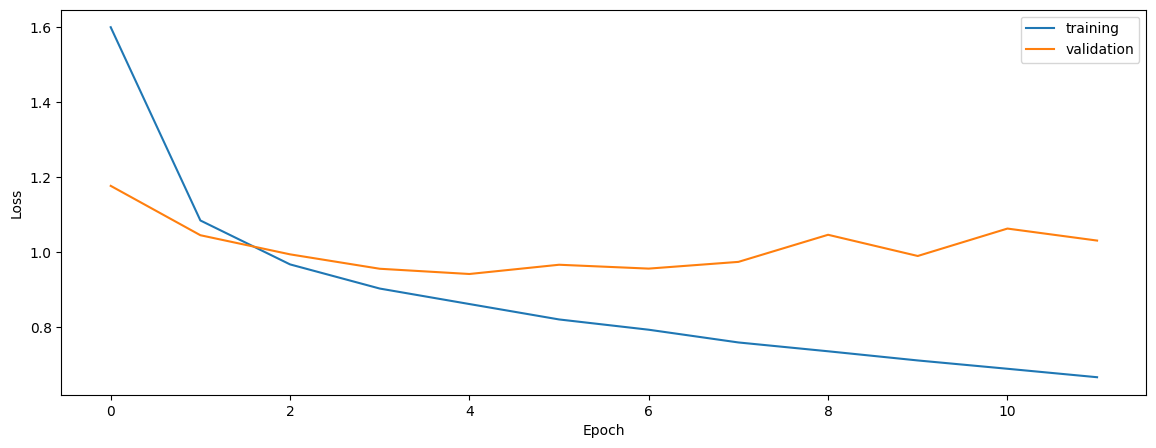

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6681552045765452
0.6345301568973715
0.6338476721763567


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.627484997668659
0.6384523029906134
0.6021442112832581


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6200633742947678
0.615195530726257
0.5932300631095812


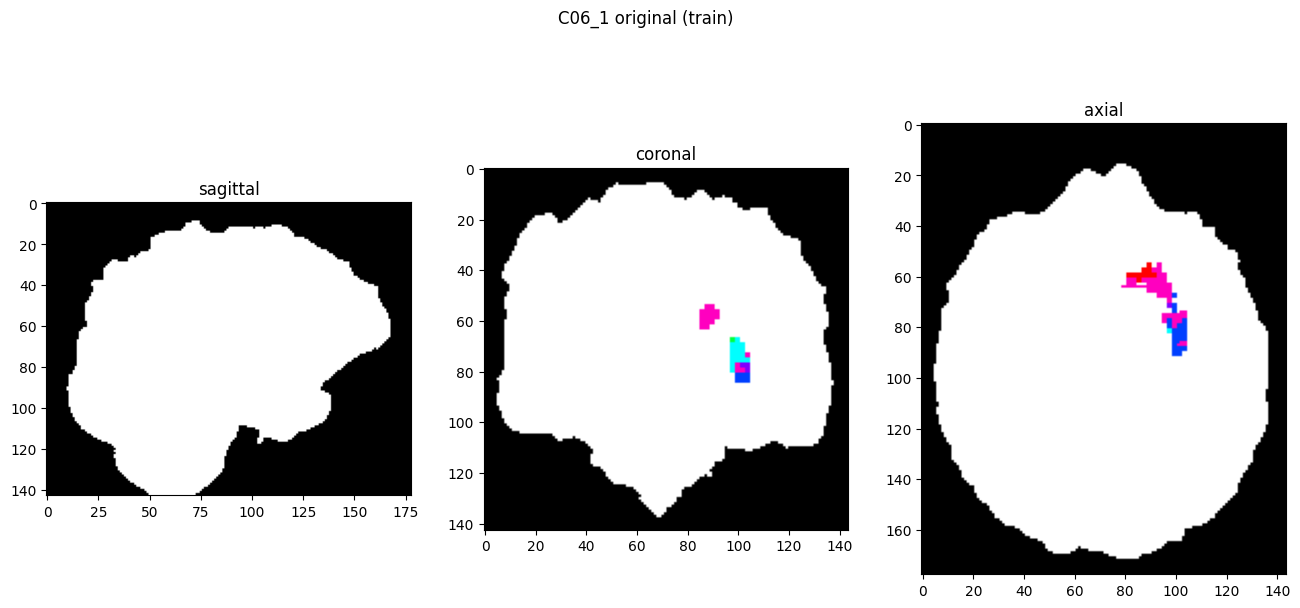

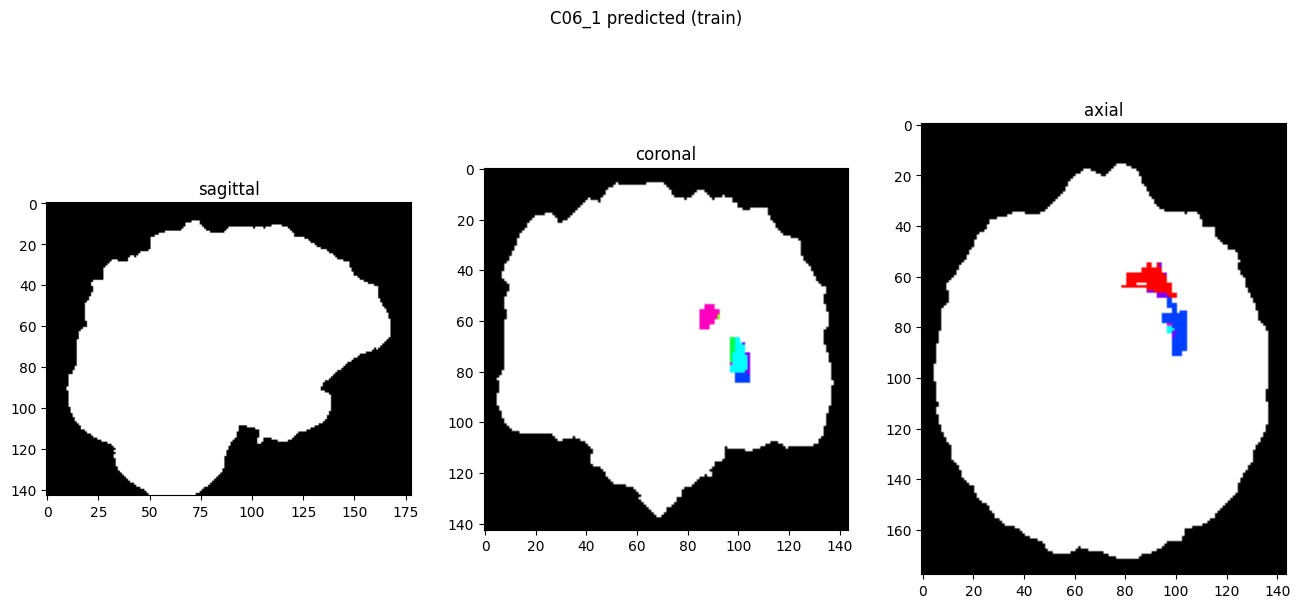

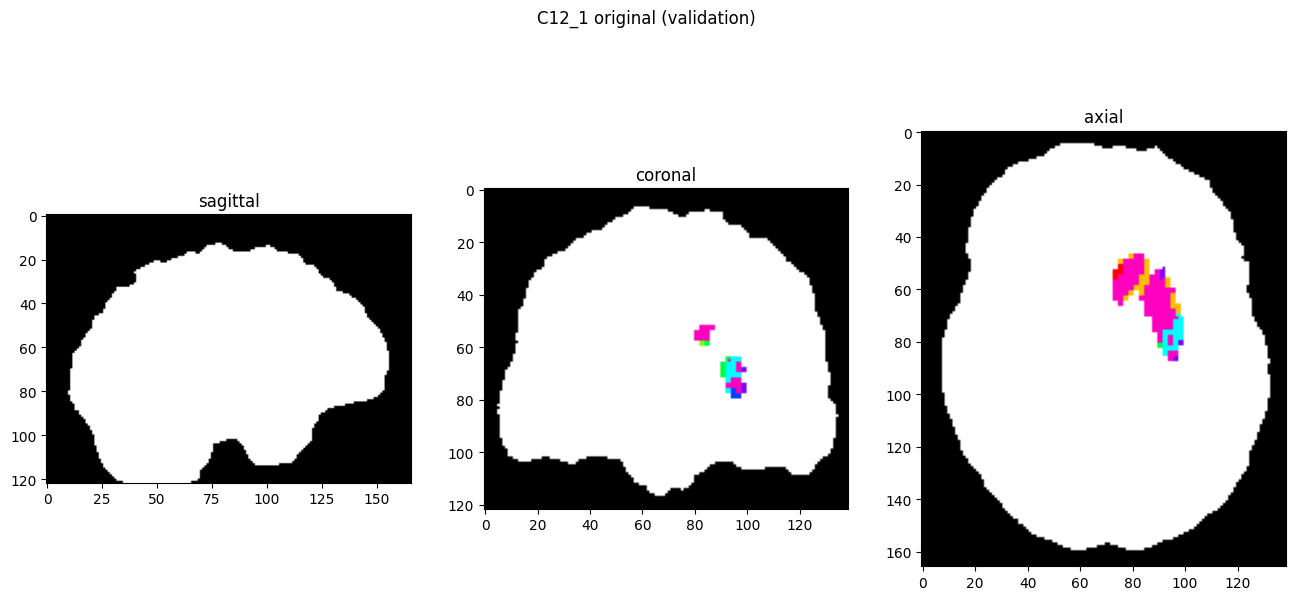

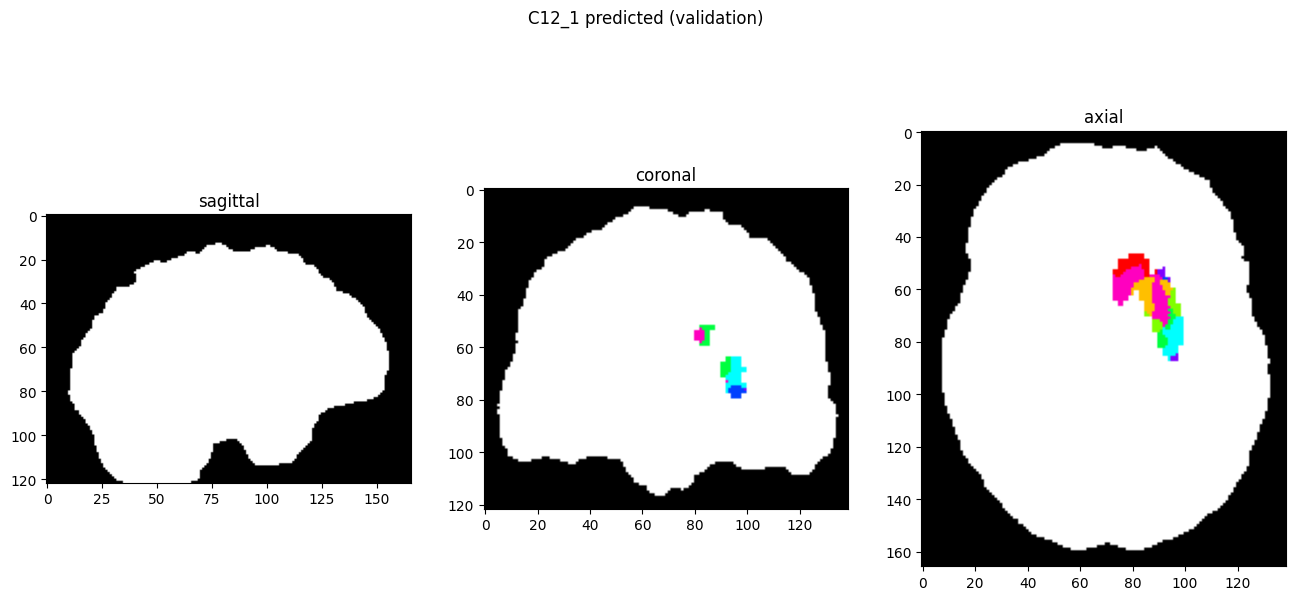

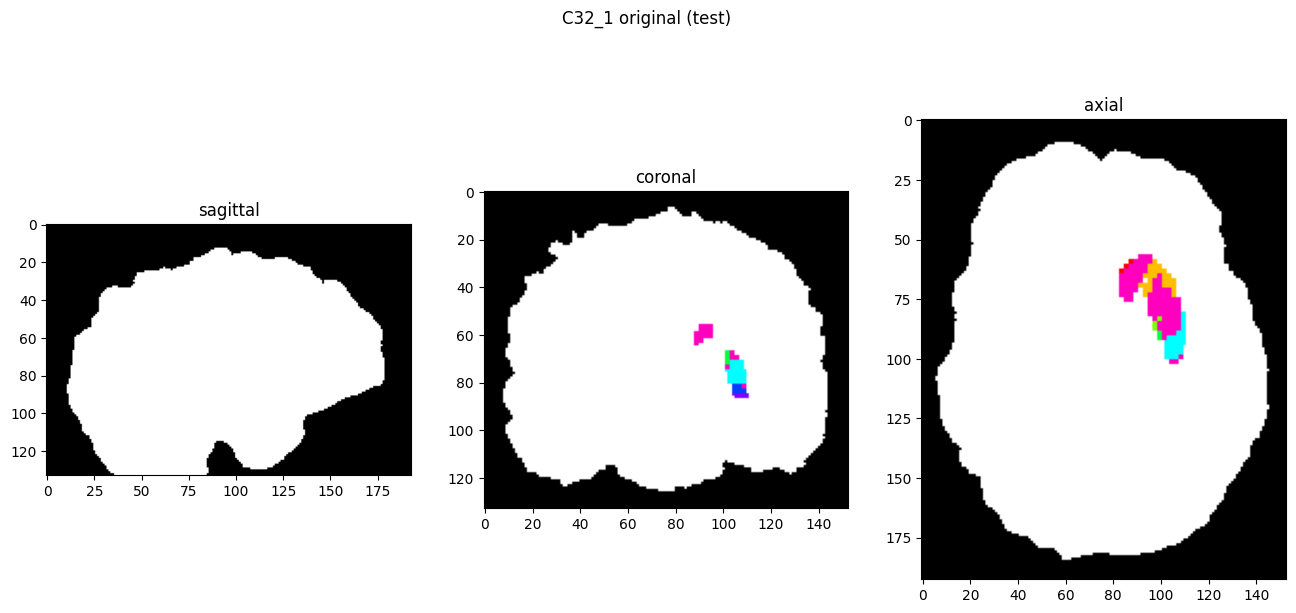

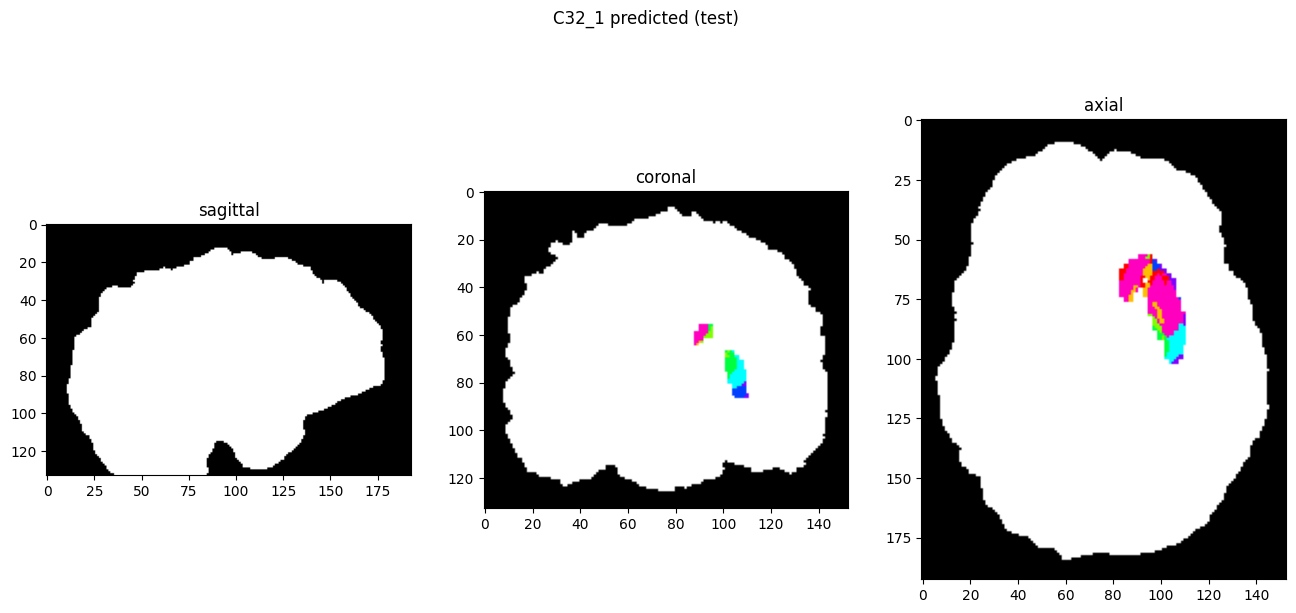

In [10]:
showResults(model, gen, threshold=0)